In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import torch
import numpy as np

from dataset import Burgers_Dataset
from unet2d import Unet2D
from diffuser import GaussianDiffusion

: 

In [2]:
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression

In [2]:
ds = Burgers_Dataset("../data/burgers_data_Nt100_v1e-02_N200.mat")

Loaded 200 samples from ../data/burgers_data_Nt100_v1e-02_N200.mat
Shape of x: torch.Size([200, 1, 100, 128])


### Visualization of the Physical Process

In [3]:
x_range = torch.linspace(0, 1, 128+1)[:-1]
t_range = torch.linspace(0, 1, 100+1)
X, T = torch.meshgrid(x_range, t_range, indexing='ij')

In [33]:
n = 31
u0 = ds.a[n]
u_traj = ds.u[n, 0]
u = torch.cat([u0, u_traj], dim=0)
u = u.permute(1, 0)

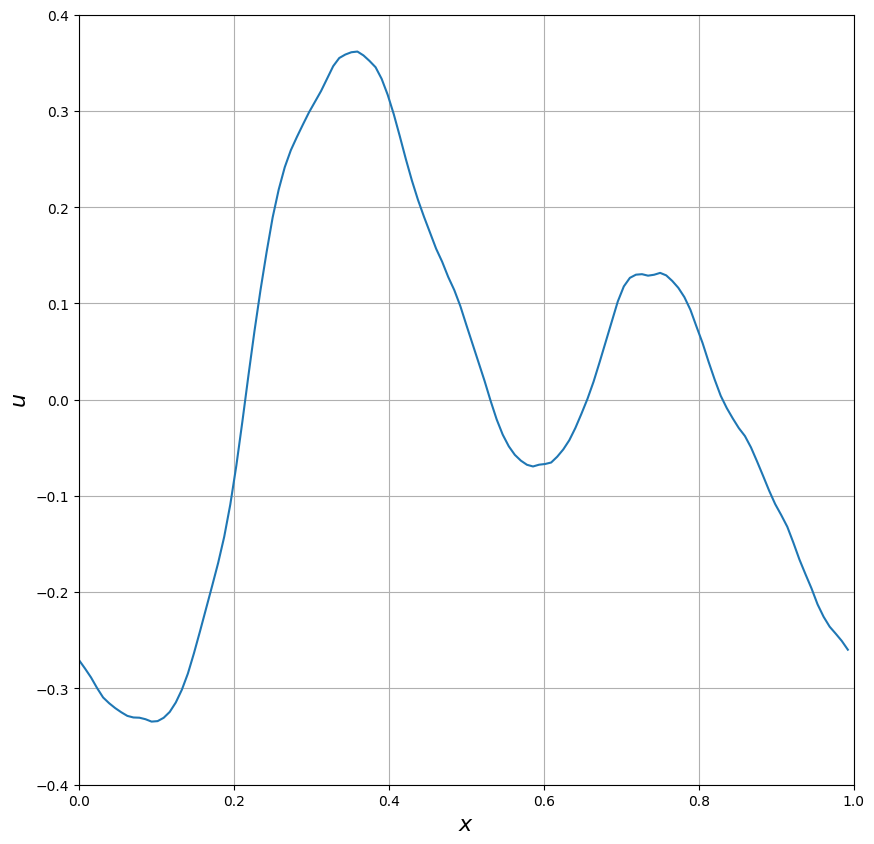

In [34]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.plot(x_range, u0.squeeze())
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$u$', fontsize=16)
ax.set_xlim([0, 1])
ax.set_ylim([-0.4, 0.4])
ax.grid()

In [14]:
fig.savefig('../assets/burgers/burgers_visualization_u0.png', dpi=300, bbox_inches='tight')

Text(0.5, 0.5, '$t$')

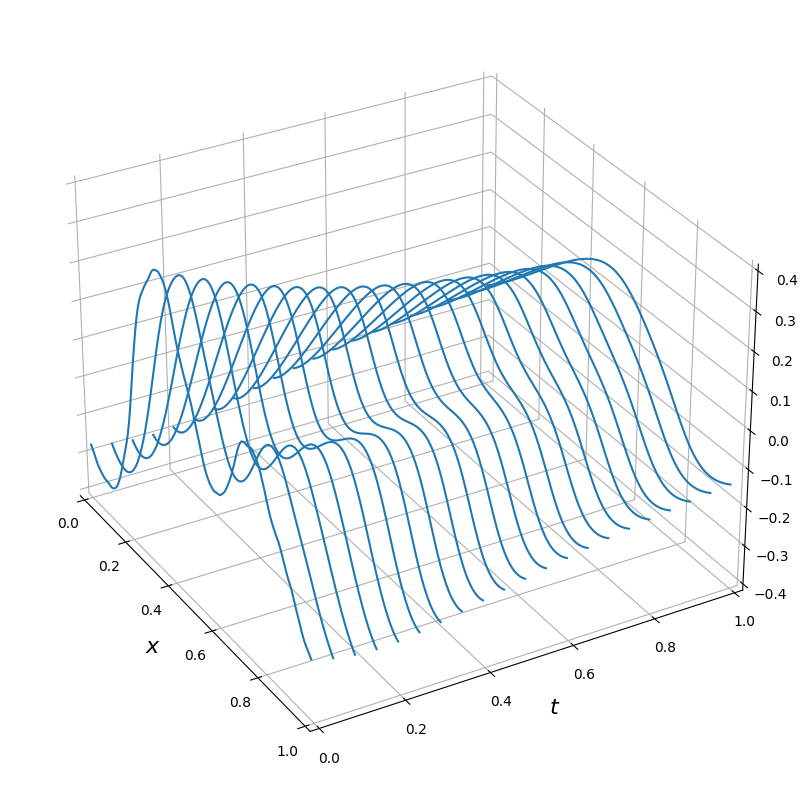

In [35]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(X, T, u, rstride=0, cstride=5)
ax.view_init(30, -30)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([-0.4, 0.4])
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$t$', fontsize=16)
# ax.set_zlabel('$u$', fontsize=16)

In [30]:
fig.savefig('../assets/burgers/burgers_visualization_uxt.png', dpi=300, bbox_inches='tight')

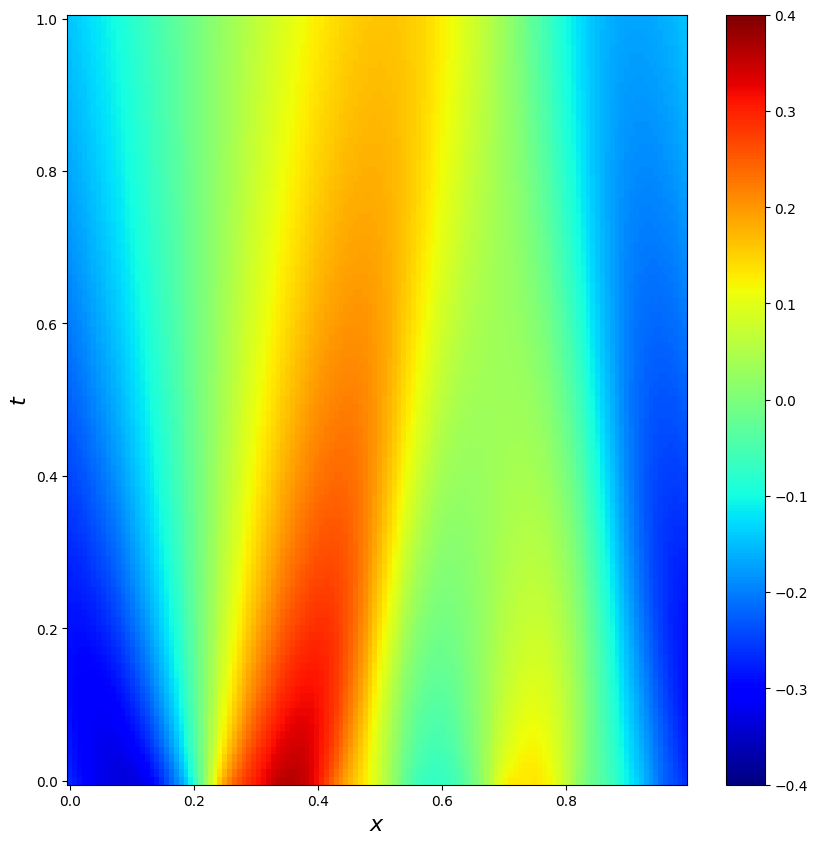

In [36]:
norm = matplotlib.colors.Normalize(vmin=-0.4, vmax=0.4)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, T, u, cmap='jet', norm=norm)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$t$', fontsize=16)
fig.colorbar(im, ax=ax)

In [37]:
fig.savefig('../assets/burgers/burgers_visualization_uxt_flatten.png', dpi=300, bbox_inches='tight')

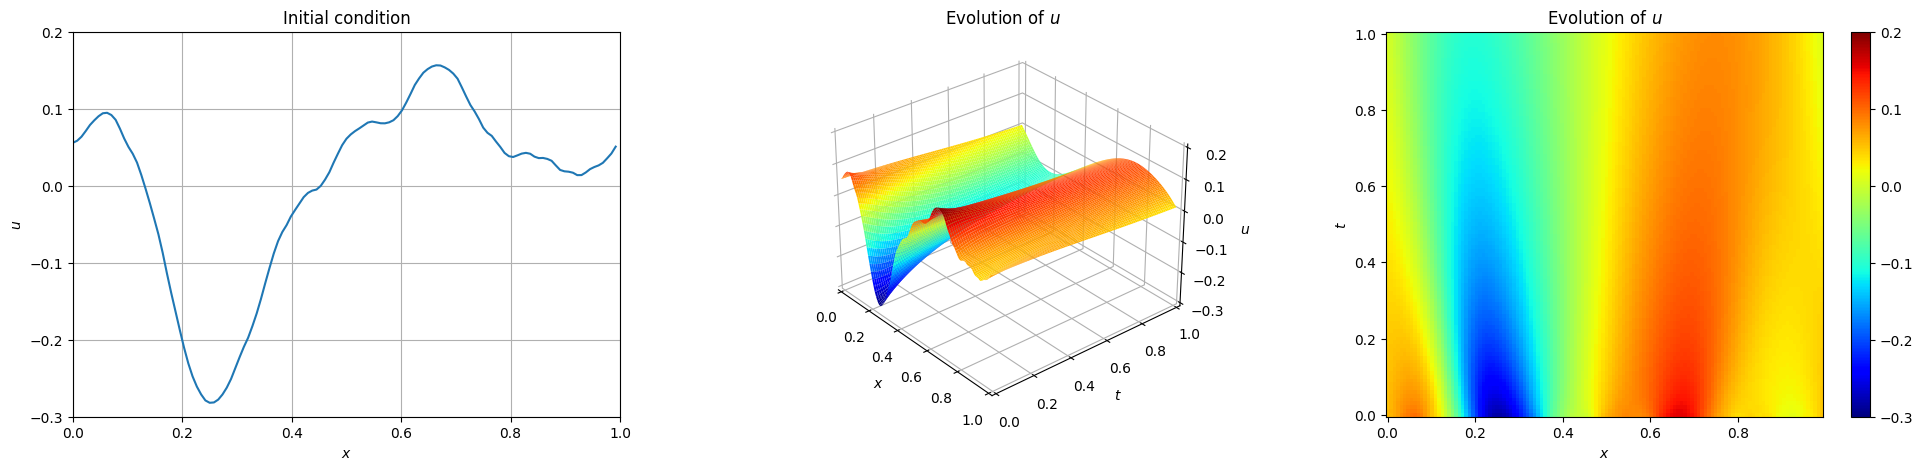

In [36]:
norm = matplotlib.colors.Normalize(vmin=-0.3, vmax=0.2)
fig = plt.figure(figsize=(24, 5))
ax1 = fig.add_subplot(131)
ax1.plot(x_range, u0.squeeze())
ax1.set_xlabel('$x$')
ax1.set_ylabel('$u$')
ax1.set_xlim([0, 1])
ax1.set_ylim([-0.3, 0.2])
ax1.grid()
ax1.set_title('Initial condition')

ax2 = fig.add_subplot(132, projection='3d')
im2 = ax2.plot_surface(X, T, u, cmap='jet', rstride=1, cstride=1)
ax2.view_init(30, -40)
ax2.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_zlim([-0.3, 0.2])
ax2.set_xlabel('$x$')
ax2.set_ylabel('$t$')
ax2.set_zlabel('$u$')
ax2.set_title('Evolution of $u$')
# fig.colorbar(im2, ax=ax2)

ax3 = fig.add_subplot(133)
im3 = ax3.pcolormesh(X, T, u, cmap='jet', norm=norm)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$t$')
ax3.set_title('Evolution of $u$')
fig.colorbar(im3, ax=ax3)
plt.show()

In [37]:
fig.savefig('../assets/burgers/burges_visualization.png', dpi=300)

### Model Test

In [3]:
device = torch.device('cuda:0')

In [4]:
model = Unet2D(
    channels=1,
    cond_channels=1,
    channel_mults=(1, 2, 4, 8),
    init_conv_channels=32,
    init_conv_kernel_size=5
)
diffusion_model = GaussianDiffusion(
    model=model,
    sample_size=(1, 100, 128),
    timesteps=800,
    objective='pred_x0',
).to(device)

In [5]:
x = ds[12:13]['x']
y = ds[12:13]['y']

In [7]:
def make_prediction(diffusion_model, cond, physics_loss_weight, error_calibration=False):
    if error_calibration and physics_loss_weight > 0.0:
        weights = torch.load(f"../ckpts/ddpm/burgers_{physics_loss_weight:.1f}phyloss(ec)/ckpt.pt", map_location={'cuda:1':'cuda:0'})
    else:
        weights = torch.load(f"../ckpts/ddpm/burgers_{physics_loss_weight:.1f}phyloss/ckpt.pt", map_location={'cuda:1':'cuda:0'})
    diffusion_model.model.load_state_dict(weights)
    x_pred = diffusion_model.sample(cond=cond)

    return x_pred.detach().cpu().squeeze()

In [8]:
x_pred00 = make_prediction(diffusion_model, y, 0.0, False)
x_pred02 = make_prediction(diffusion_model, y, 0.2, False)
x_pred05 = make_prediction(diffusion_model, y, 0.5, False)
x_pred10 = make_prediction(diffusion_model, y, 1.0, False)
x_pred02ec = make_prediction(diffusion_model, y, 0.2, True)
x_pred05ec = make_prediction(diffusion_model, y, 0.5, True)
x_pred10ec = make_prediction(diffusion_model, y, 1.0, True)

DDPM sampling: 100%|██████████| 800/800 [00:31<00:00, 25.73it/s]


In [10]:
x_range = torch.linspace(0, 1, 128+1)[:-1]
t_range = torch.linspace(0, 1, 100+1)[1:]
X, T = torch.meshgrid(x_range, t_range, indexing='ij')

In [9]:
x = x.squeeze()
y = y.squeeze()
# x_pred02ec = x_pred02ec.squeeze()

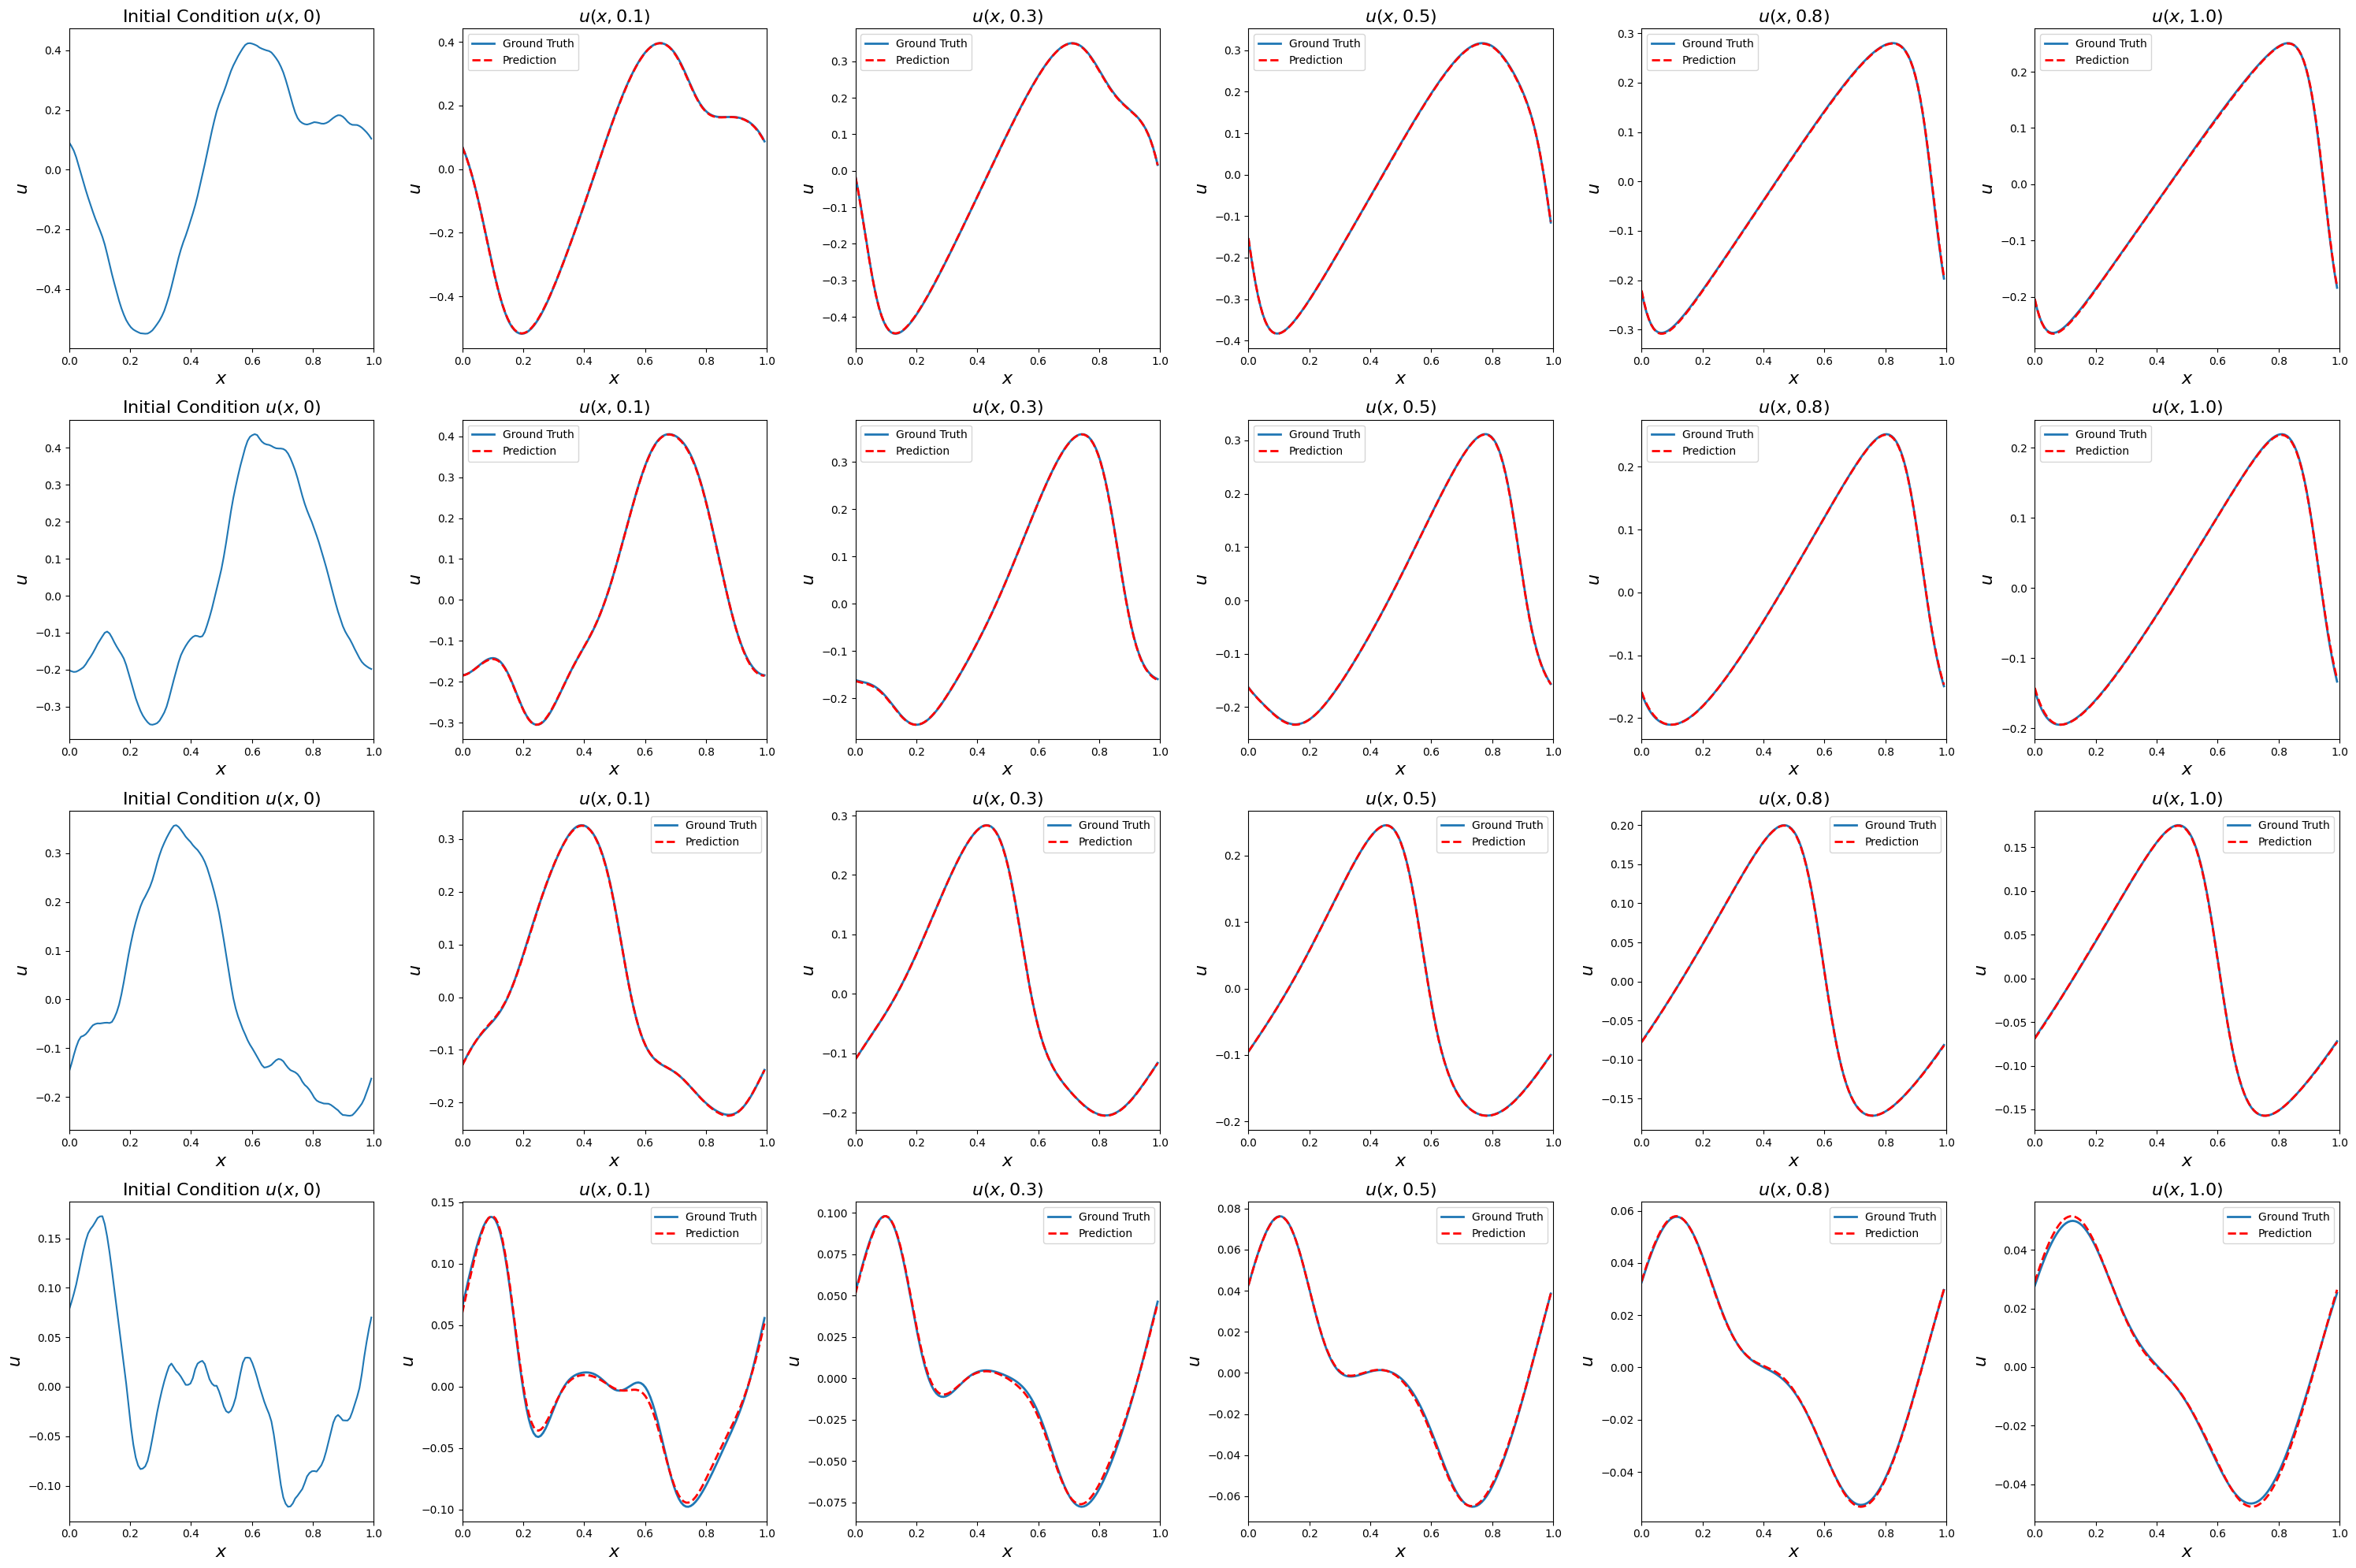

In [12]:
fig, ax = plt.subplots(4, 6, figsize=(30, 20))
for i in range(4):
    ax[i, 0].plot(x_range, y[i])
    ax[i, 0].set_xlabel('$x$', fontsize=16)
    ax[i, 0].set_ylabel('$u$', fontsize=16)
    ax[i, 0].set_title('Initial Condition $u(x, 0)$', fontsize=16)
    ax[i, 0].set_xlim([0, 1])
    plt.tight_layout()

    ax[i, 1].plot(x_range, x[i, 9], linewidth=2, label='Ground Truth')
    ax[i, 1].plot(x_range, x_pred02ec[i, 9], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 1].set_xlabel('$x$', fontsize=16)
    ax[i, 1].set_ylabel('$u$', fontsize=16)
    ax[i, 1].set_xlim([0, 1])
    ax[i, 1].set_title('$u(x, 0.1)$', fontsize=16)
    ax[i, 1].legend()
    plt.tight_layout()

    ax[i, 2].plot(x_range, x[i, 29], linewidth=2, label='Ground Truth')
    ax[i, 2].plot(x_range, x_pred02ec[i, 29], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 2].set_xlabel('$x$', fontsize=16)
    ax[i, 2].set_ylabel('$u$', fontsize=16)
    ax[i, 2].set_xlim([0, 1])
    ax[i, 2].set_title('$u(x, 0.3)$', fontsize=16)
    ax[i, 2].legend()
    plt.tight_layout()

    ax[i, 3].plot(x_range, x[i, 49], linewidth=2, label='Ground Truth')
    ax[i, 3].plot(x_range, x_pred02ec[i, 49], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 3].set_xlabel('$x$', fontsize=16)
    ax[i, 3].set_ylabel('$u$', fontsize=16)
    ax[i, 3].set_xlim([0, 1])
    ax[i, 3].set_title('$u(x, 0.5)$', fontsize=16)
    ax[i, 3].legend()
    plt.tight_layout()

    ax[i, 4].plot(x_range, x[i, 79], linewidth=2, label='Ground Truth')
    ax[i, 4].plot(x_range, x_pred02ec[i, 79], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 4].set_xlabel('$x$', fontsize=16)
    ax[i, 4].set_ylabel('$u$', fontsize=16)
    ax[i, 4].set_xlim([0, 1])
    ax[i, 4].set_title('$u(x, 0.8)$', fontsize=16)
    ax[i, 4].legend()
    plt.tight_layout()

    ax[i, 5].plot(x_range, x[i, 99], linewidth=2, label='Ground Truth')
    ax[i, 5].plot(x_range, x_pred02ec[i, 99], linewidth=2, color='red', linestyle='--', label='Prediction')
    ax[i, 5].set_xlabel('$x$', fontsize=16)
    ax[i, 5].set_ylabel('$u$', fontsize=16)
    ax[i, 5].set_xlim([0, 1])
    ax[i, 5].set_title('$u(x, 1.0)$', fontsize=16)
    ax[i, 5].legend()
    plt.tight_layout()

In [14]:
fig.savefig('../assets/burgers/burgers_prediction.png', dpi=300, bbox_inches='tight')

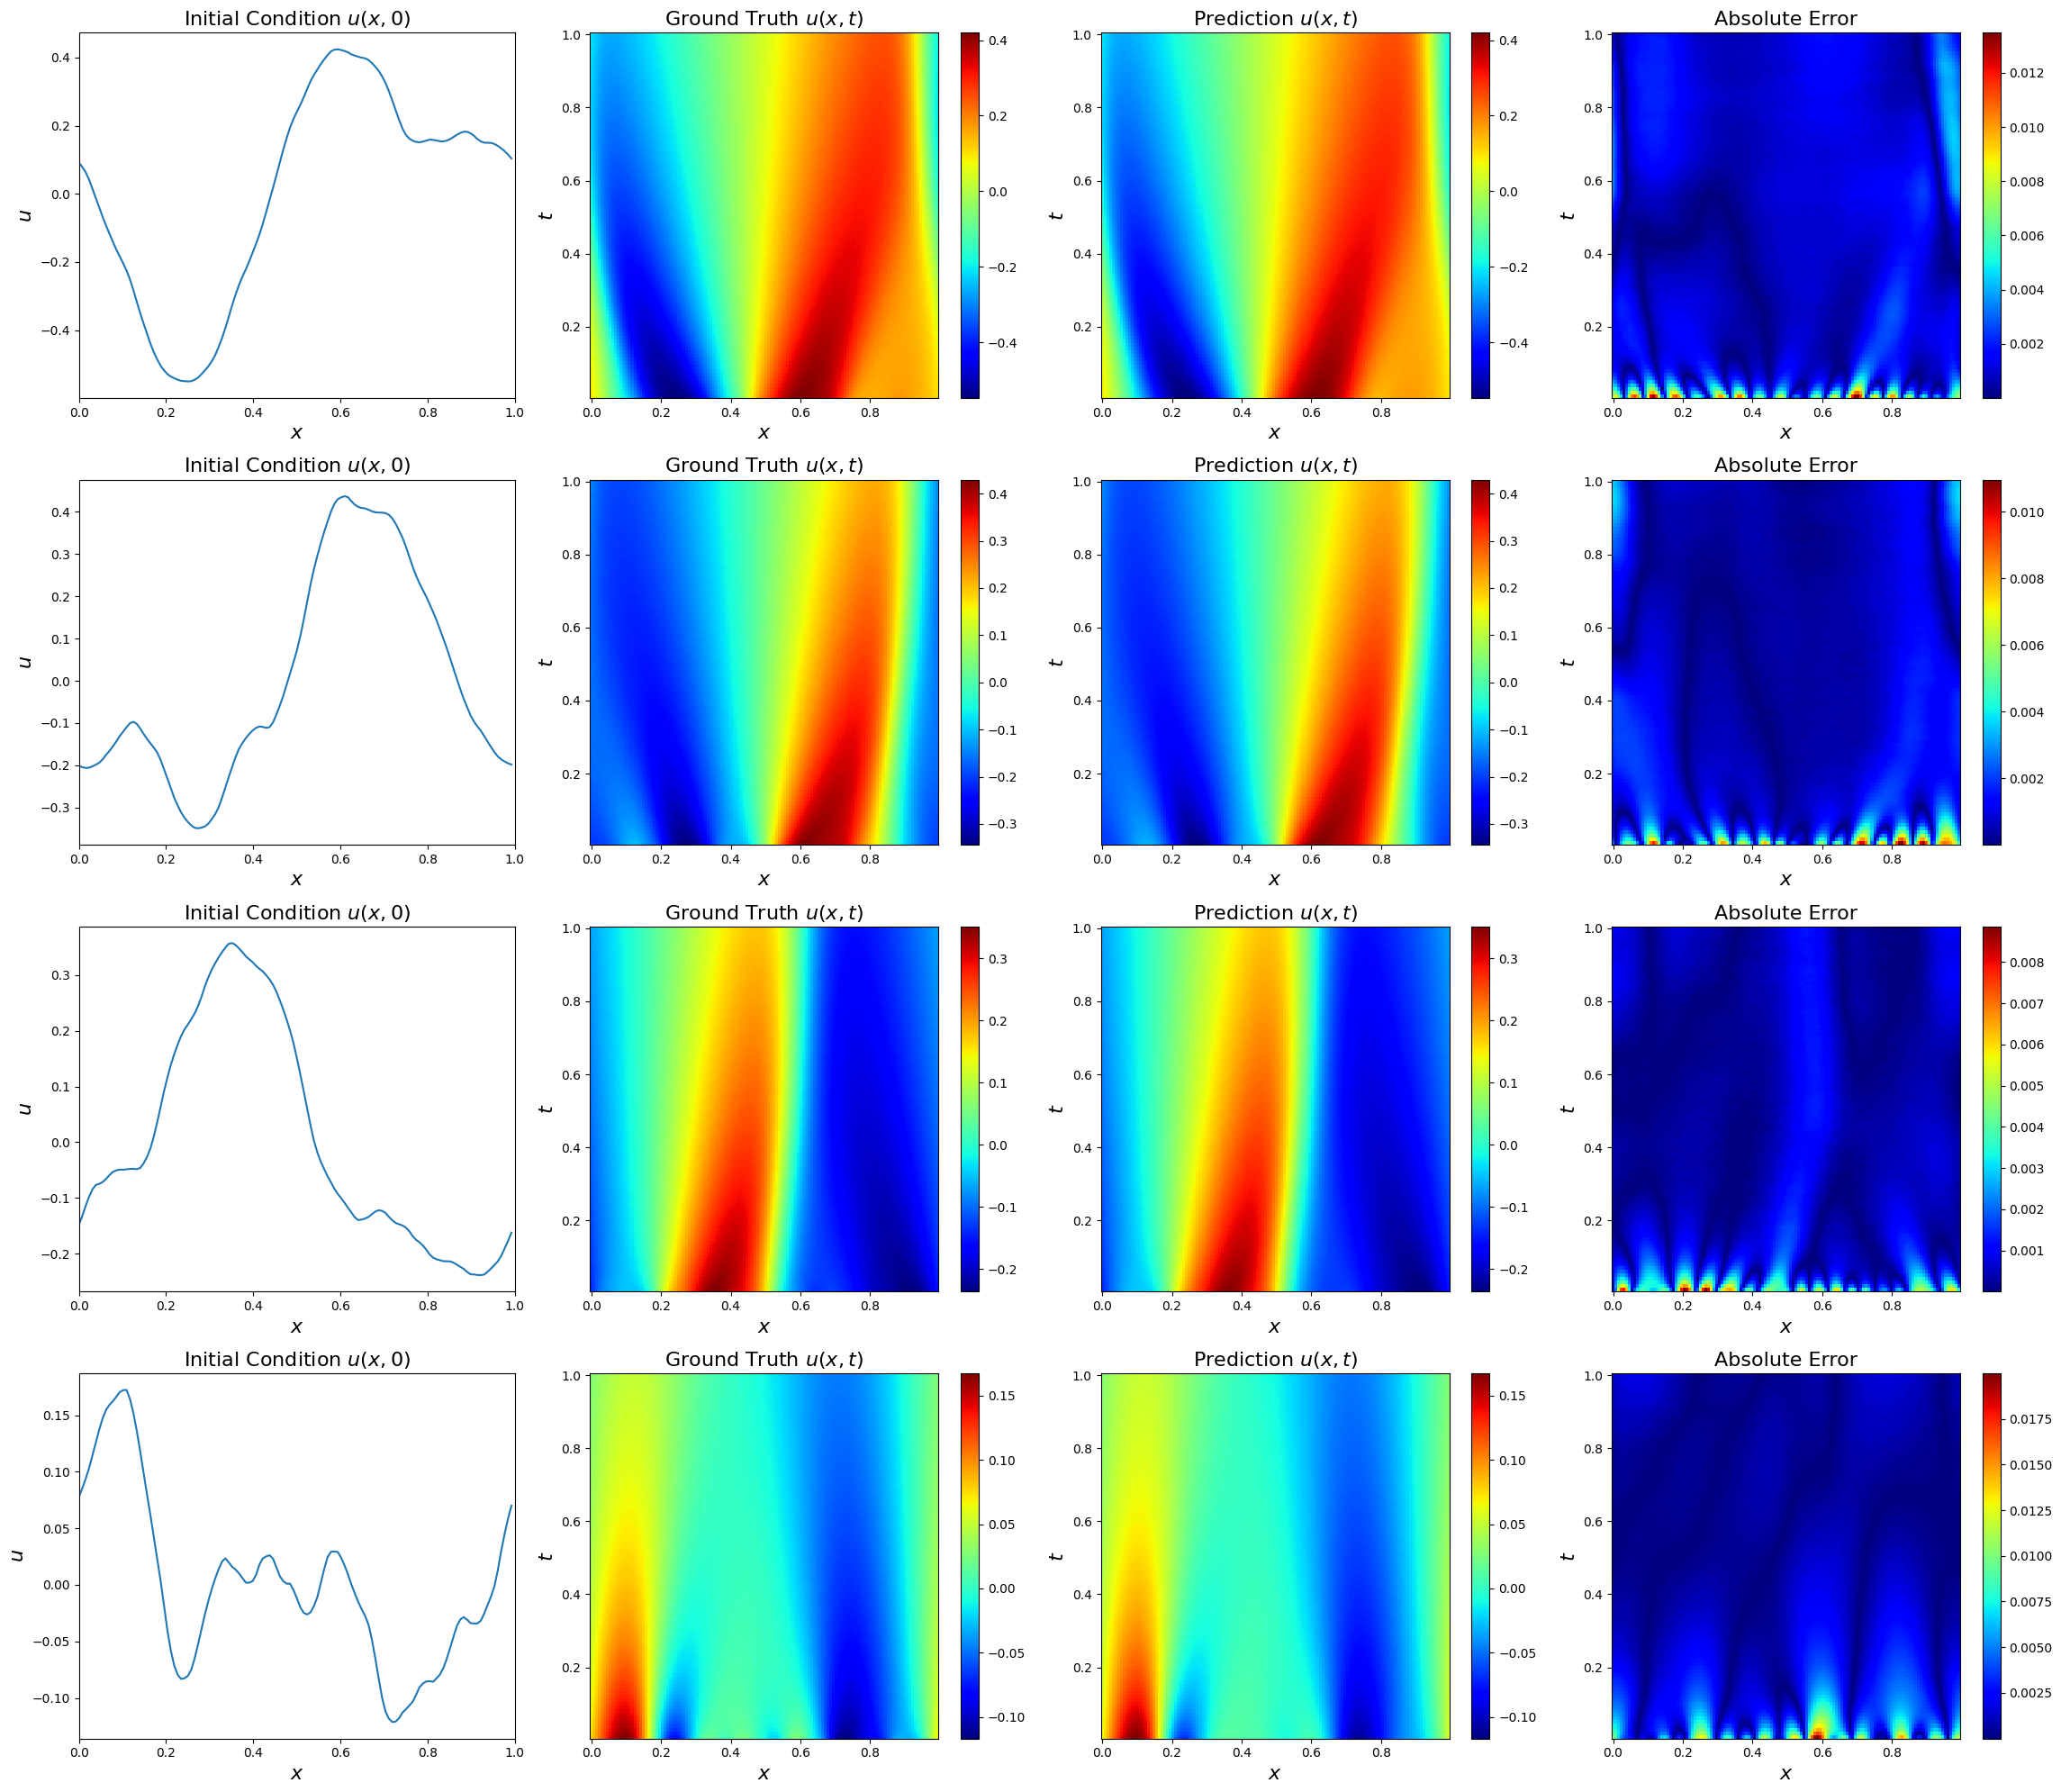

In [82]:
fig, ax = plt.subplots(4, 4, figsize=(23, 20))
for i in range(4):
    ax[i, 0].plot(x_range, y[i])
    ax[i, 0].set_xlabel('$x$', fontsize=16)
    ax[i, 0].set_ylabel('$u$', fontsize=16)
    ax[i, 0].set_title('Initial Condition $u(x, 0)$', fontsize=16)
    ax[i, 0].set_xlim([0, 1])
    plt.tight_layout()

    norm1 = matplotlib.colors.Normalize(vmin=x[i].min(), vmax=x[i].max())
    im1 = ax[i, 1].pcolormesh(X, T, x[i].T, cmap='jet', norm=norm1)
    ax[i, 1].set_xlabel('$x$', fontsize=16)
    ax[i, 1].set_ylabel('$t$', fontsize=16)
    ax[i, 1].set_title('Ground Truth $u(x, t)$', fontsize=16)
    # ax[i, 1].set_axis('square')
    fig.colorbar(im1, ax=ax[i, 1])
    plt.tight_layout()

    im2 = ax[i, 2].pcolormesh(X, T, x_pred02ec[i].T, cmap='jet', norm=norm1)
    ax[i, 2].set_xlabel('$x$', fontsize=16)
    ax[i, 2].set_ylabel('$t$', fontsize=16)
    ax[i, 2].set_title('Prediction $u(x, t)$', fontsize=16)
    # ax[i, 2].set_axis('square')
    fig.colorbar(im2, ax=ax[i, 2])
    plt.tight_layout()

    norm2 = matplotlib.colors.Normalize(vmin=0, vmax=np.abs(x[i]).max())
    im3 = ax[i, 3].pcolormesh(X, T, (torch.abs(x[i]-x_pred02ec[i])).T, cmap='jet')
    ax[i, 3].set_xlabel('$x$', fontsize=16)
    ax[i, 3].set_ylabel('$t$', fontsize=16)
    ax[i, 3].set_title('Absolute Error', fontsize=16)
    # ax[i, 3].set_axis('square')
    fig.colorbar(im3, ax=ax[i, 3])
    plt.tight_layout()

In [83]:
fig.savefig('../assets/burgers/whole_traj_comparsion.png', bbox_inches='tight', dpi=300)

In [14]:
x = x.numpy()
x_pred02ec = x_pred02ec.numpy()
# compute the correlation efficient between ground truth and prediction for each sample at each time step
coeff1 = np.array([np.corrcoef(x[0, i], x_pred02ec[0, i])[0, 1] for i in range(100)])
coeff2 = np.array([np.corrcoef(x[1, i], x_pred02ec[1, i])[0, 1] for i in range(100)])
coeff3 = np.array([np.corrcoef(x[2, i], x_pred02ec[2, i])[0, 1] for i in range(100)])
coeff4 = np.array([np.corrcoef(x[3, i], x_pred02ec[3, i])[0, 1] for i in range(100)])

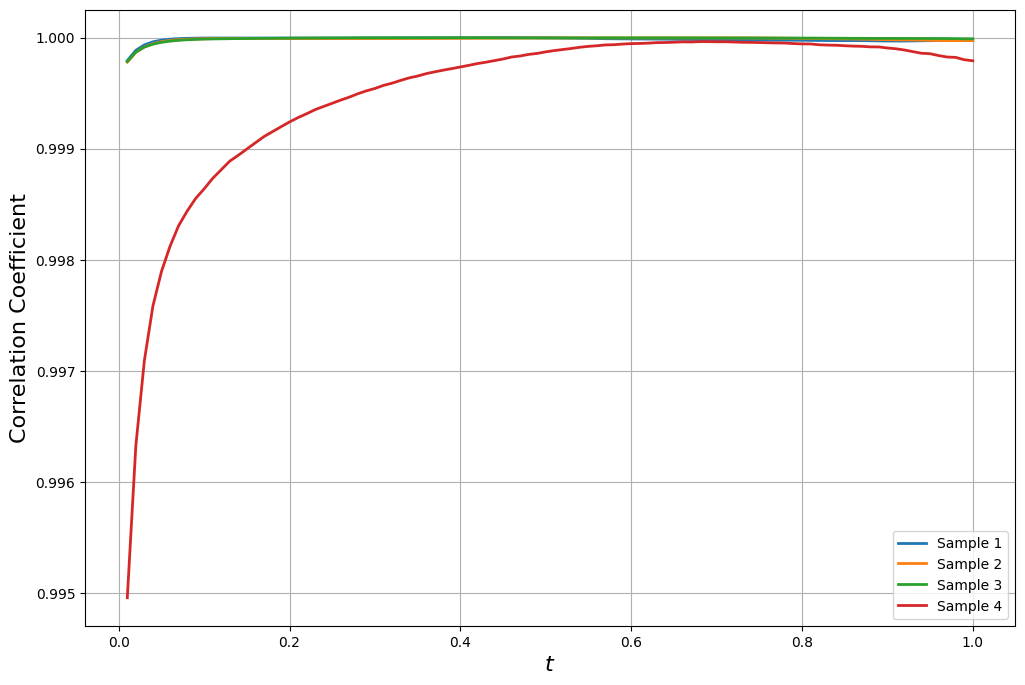

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(t_range, coeff1, linewidth=2, label='Sample 1')
ax.plot(t_range, coeff2, linewidth=2, label='Sample 2')
ax.plot(t_range, coeff3, linewidth=2, label='Sample 3')
ax.plot(t_range, coeff4, linewidth=2, label='Sample 4')
ax.set_xlabel('$t$', fontsize=16)
ax.set_ylabel('Correlation Coefficient', fontsize=16)
ax.grid()
ax.legend()

In [20]:
fig.savefig('../assets/burgers/correlation_coefficient.png', bbox_inches='tight', dpi=300)

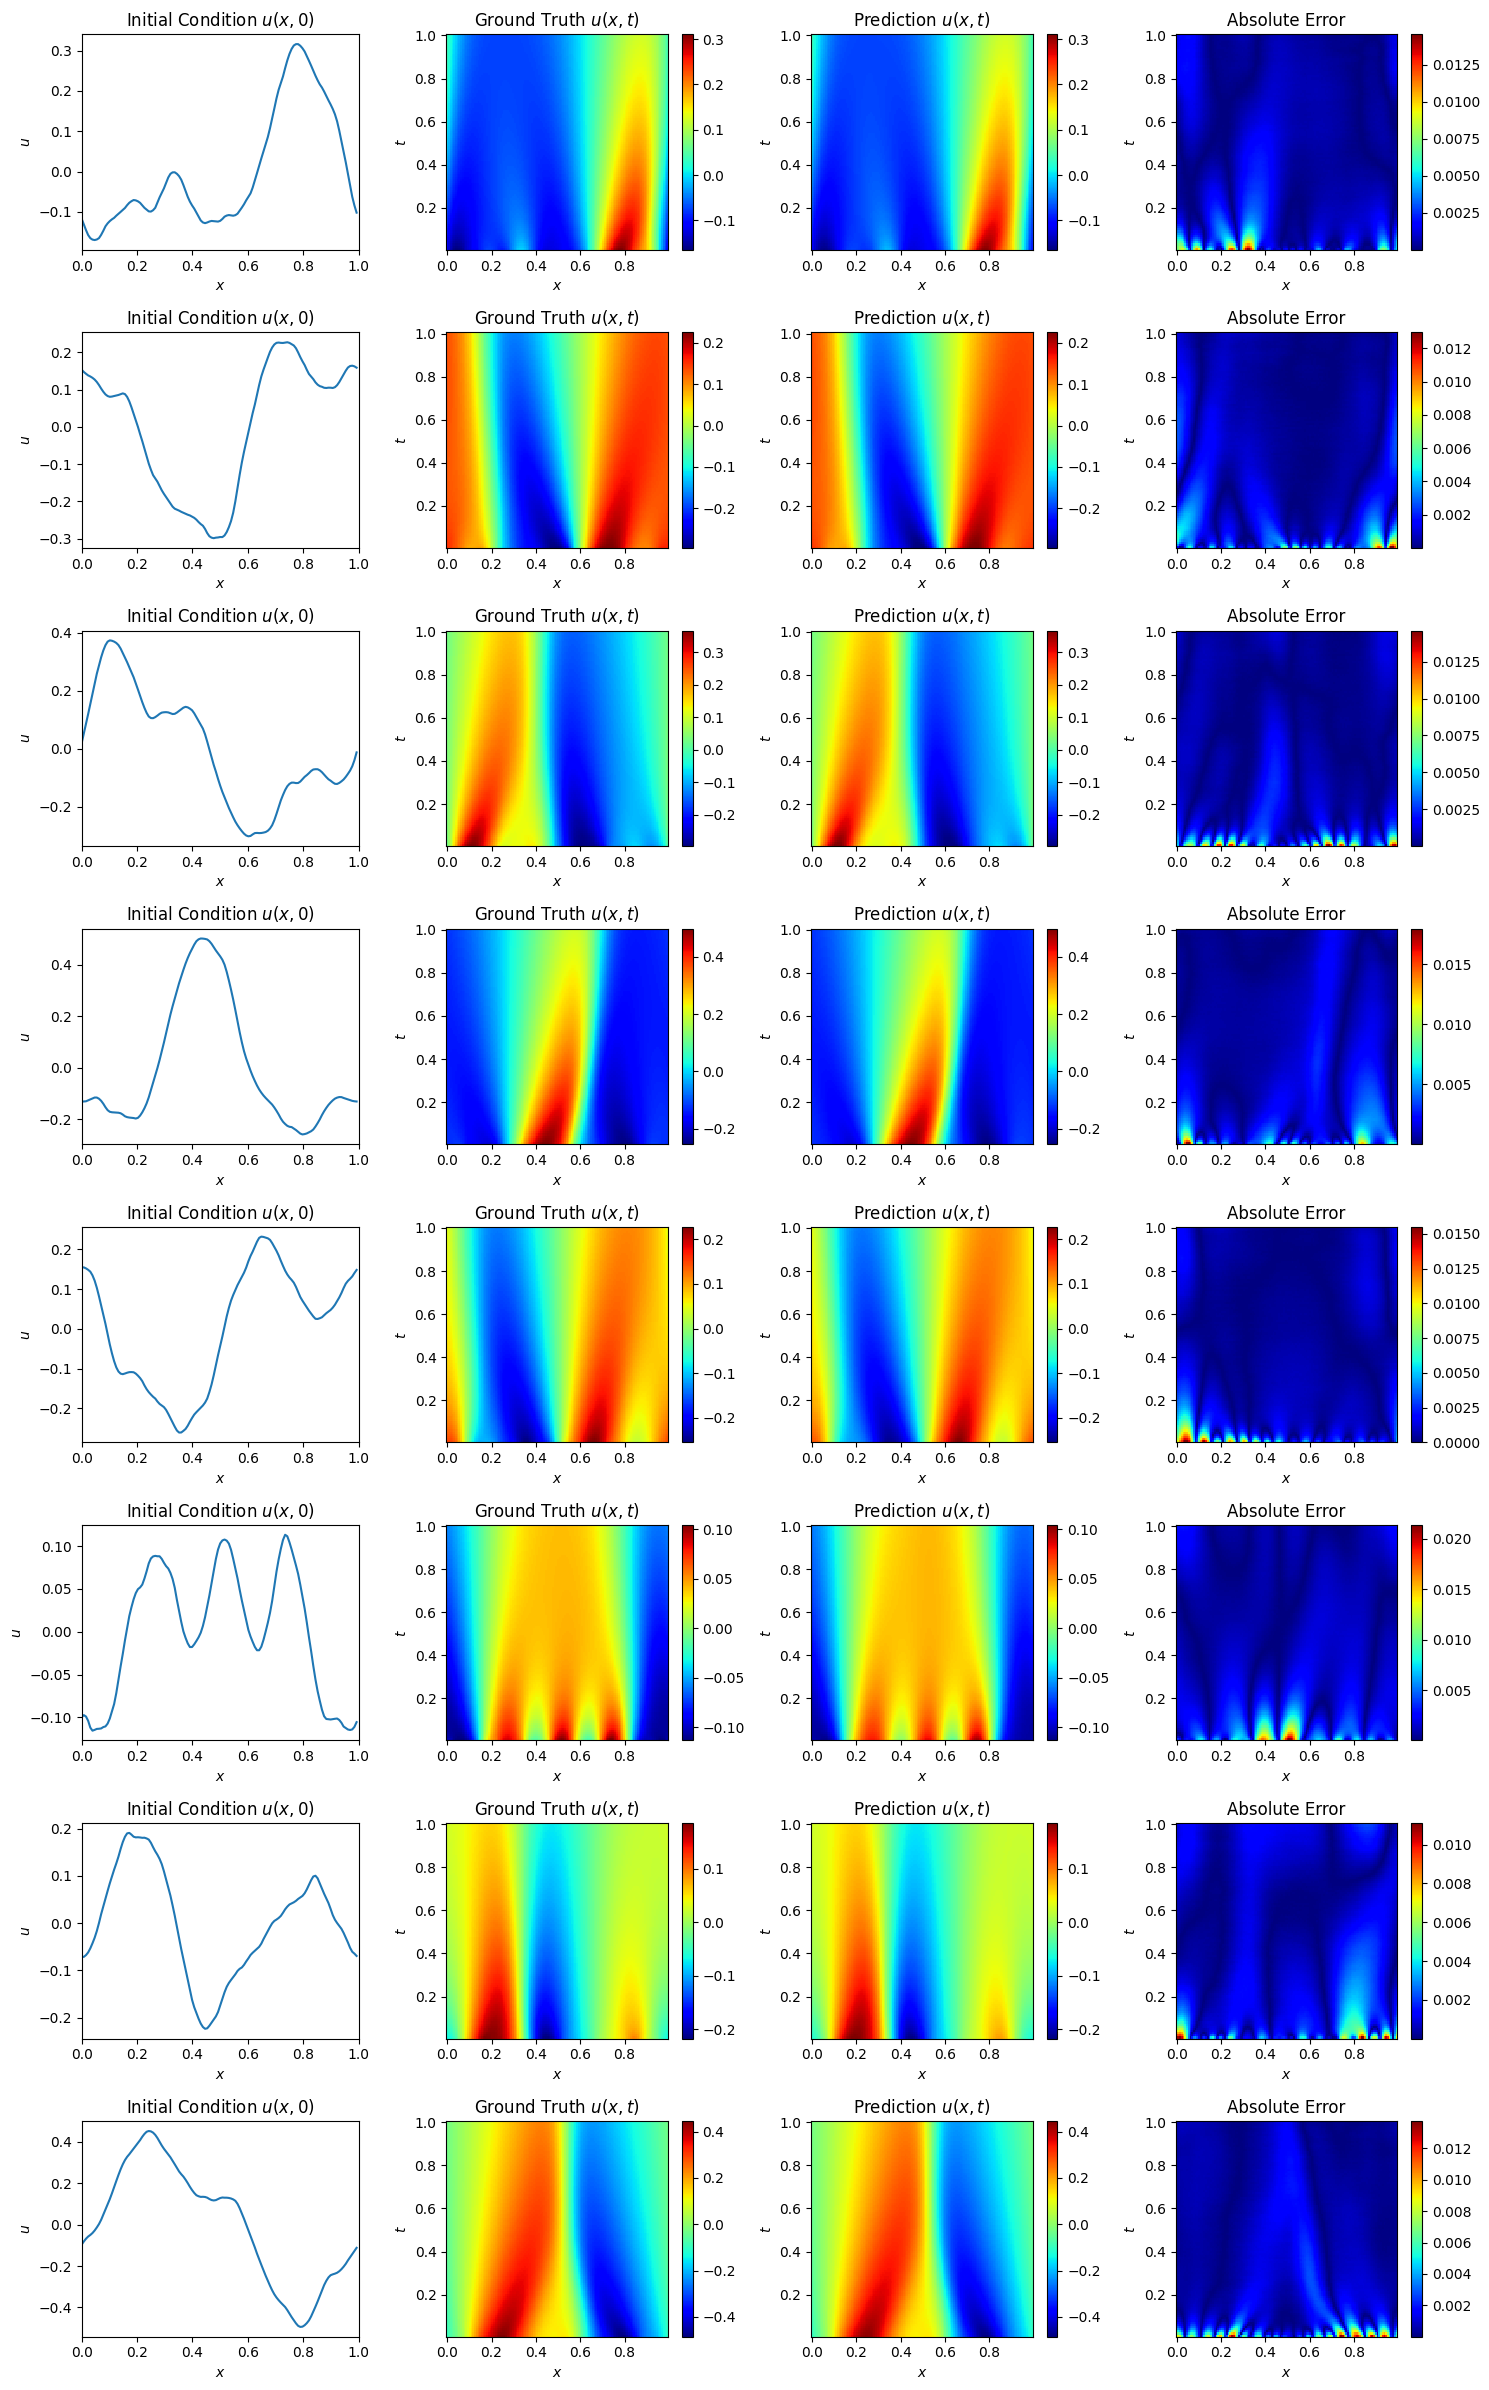

In [84]:
fig, ax = plt.subplots(8, 4, figsize=(15, 24))
for i in range(8):
    ax[i, 0].plot(x_range, y[i+4].squeeze())
    ax[i, 0].set_xlabel('$x$')
    ax[i, 0].set_ylabel('$u$')
    ax[i, 0].set_title('Initial Condition $u(x, 0)$')
    ax[i, 0].set_xlim([0, 1])
    plt.tight_layout()

    norm1 = matplotlib.colors.Normalize(vmin=x[i+4].min(), vmax=x[i+4].max())
    im1 = ax[i, 1].pcolormesh(X, T, x[i+4].T, cmap='jet', norm=norm1)
    ax[i, 1].set_xlabel('$x$')
    ax[i, 1].set_ylabel('$t$')
    ax[i, 1].set_title('Ground Truth $u(x, t)$')
    # ax[i, 1].set_axis('square')
    fig.colorbar(im1, ax=ax[i, 1])
    plt.tight_layout()

    im2 = ax[i, 2].pcolormesh(X, T, x_pred02ec[i+4].T, cmap='jet', norm=norm1)
    ax[i, 2].set_xlabel('$x$')
    ax[i, 2].set_ylabel('$t$')
    ax[i, 2].set_title('Prediction $u(x, t)$')
    # ax[i, 2].set_axis('square')
    fig.colorbar(im2, ax=ax[i, 2])
    plt.tight_layout()

    im3 = ax[i, 3].pcolormesh(X, T, torch.abs(x[i+4]-x_pred02ec[i+4]).T, cmap='jet')
    ax[i, 3].set_xlabel('$x$')
    ax[i, 3].set_ylabel('$t$')
    ax[i, 3].set_title('Absolute Error')
    # ax[i, 3].set_axis('square')
    fig.colorbar(im3, ax=ax[i, 3])
    plt.tight_layout()

In [85]:
fig.savefig('../assets/burgers/whole_traj_comparsion_2.png', bbox_inches='tight', dpi=300)

### Make movie

In [21]:
import matplotlib.animation as animation

In [92]:
x_pred = x_pred02ec

In [108]:
def make_animation(x, x_pred):
    x = x.squeeze()
    x_pred = x_pred.squeeze()
    fig, ax = plt.subplots(3, 4, figsize=(20, 15))
    line = []
    for i in range(3):
        for j in range(4):
            ax[i, j].set_xlim([0, 1])
            ax[i, j].set_ylim(x[j].min(), x[j].max())

            line.extend(ax[i, j].plot([], [], linewidth=2))
    for j in range(4):
        ax[2, j].set_ylim((x[j]-x_pred[j]).min(), (x[j]-x_pred[j]).max())
        ax[2, j].set_xlabel('$x$')
    
    ax[0, 0].set_ylabel('$u$')
    ax[1, 0].set_ylabel('$u$')
    ax[2, 0].set_ylabel('Error')

    x_span = torch.linspace(0, 1, 128)

    def update(frame, x, x_pred):
        for j in range(4):
            line[j].set_data(x_span, x[j, frame])
            line[j+4].set_data(x_span, x_pred[j, frame])
            line[j+8].set_data(x_span, x[j, frame]-x_pred[j, frame])

        for i in range(3):
            for j in range(4):
                ax[i, j].set_title(f'$t={frame/100:.2f}$')
                
        return line
    
    ani = animation.FuncAnimation(fig, update, frames=100, fargs=(x, x_pred), blit=False)
    return ani

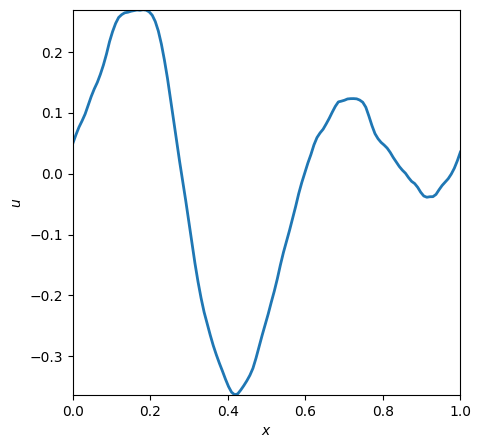

In [9]:
x0 = y.squeeze()[3]
plt.figure(figsize=(5, 5))
plt.plot(torch.linspace(0, 1, 128), x0, lw=2)
plt.xlim([0, 1])
plt.ylim(x0.min(), x0.max())
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.savefig('../assets/burgers/bs_input4.png', bbox_inches='tight', dpi=300)

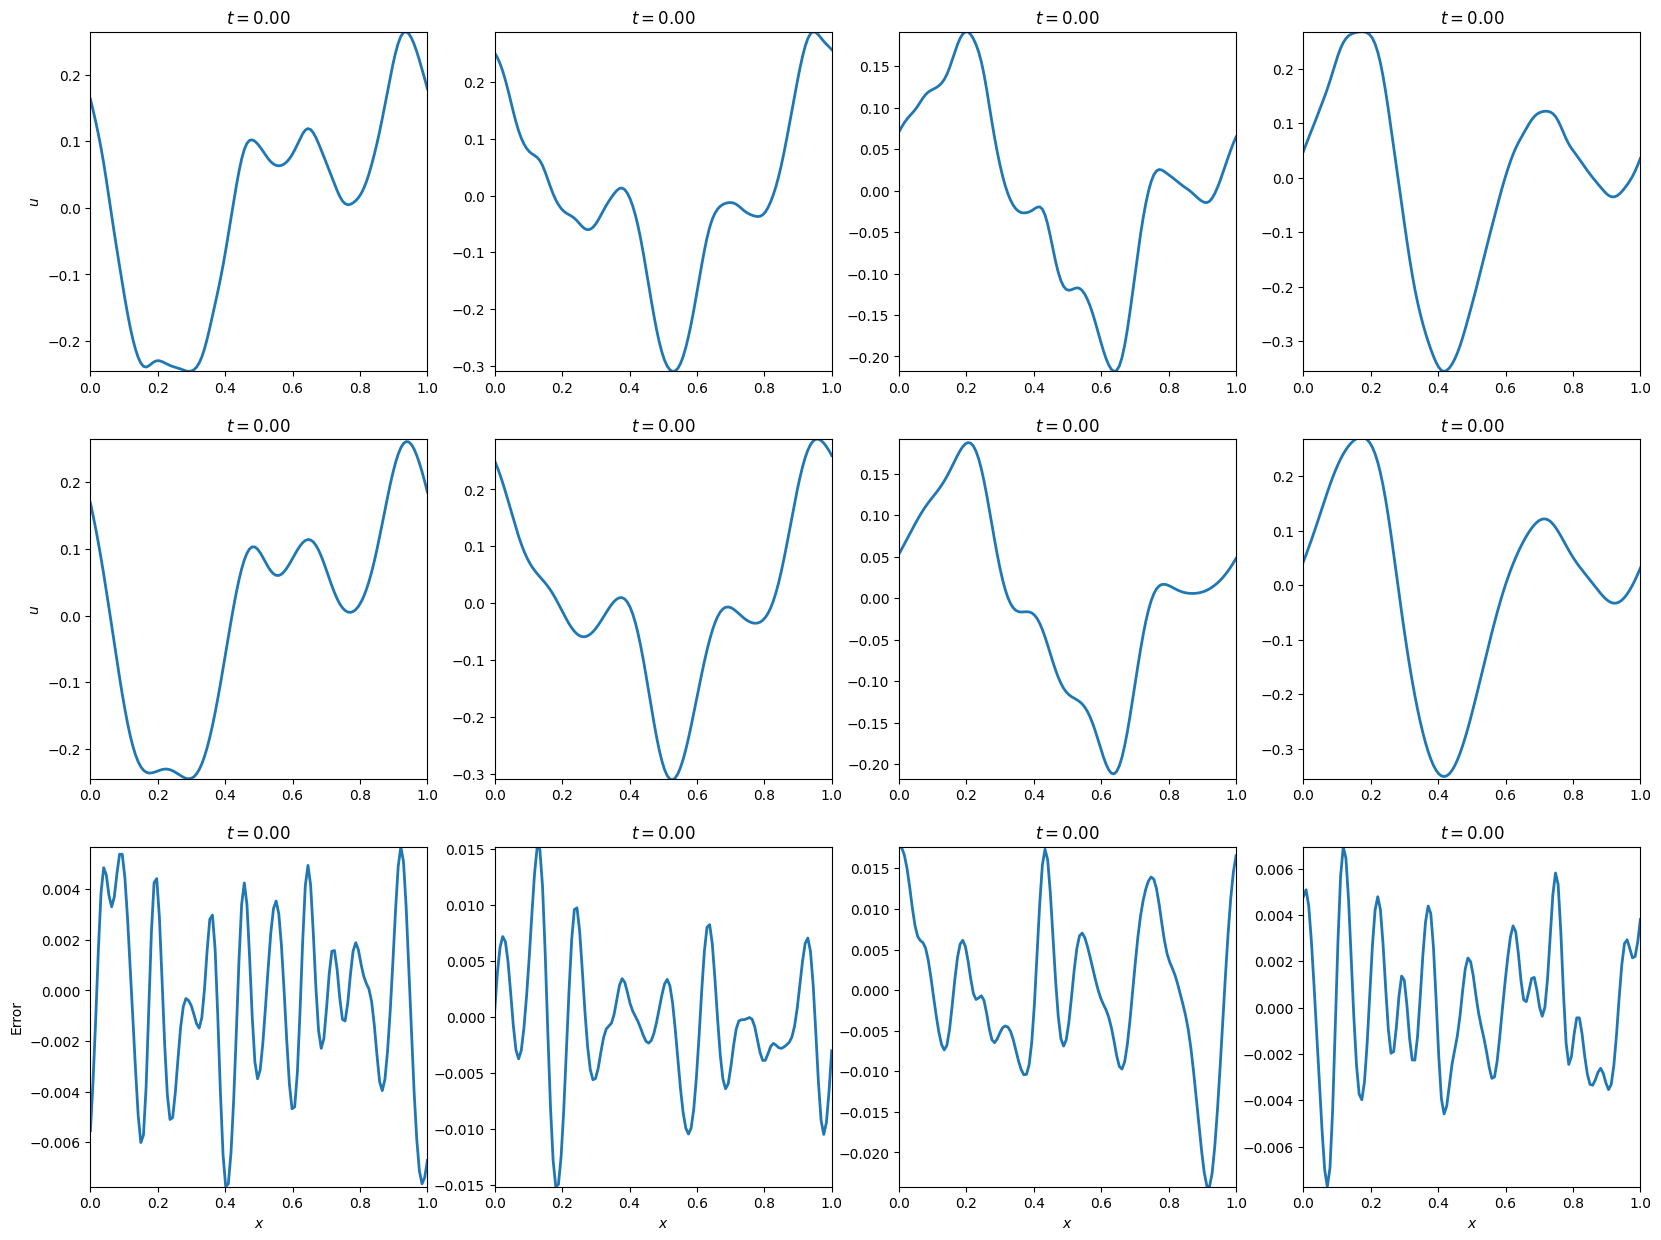

In [109]:
ani = make_animation(x, x_pred)
ani.save('../assets/burgers/bs_animation.gif', writer='pillow', fps=10)

### Mean and Variance of Prediction

In [12]:
x1 = ds[71:72]['x']
y1 = ds[71:72]['y']
x2 = ds[72:73]['x']
y2 = ds[72:73]['y']
x3 = ds[73:74]['x']
y3 = ds[73:74]['y']
x4 = ds[74:75]['x']
y4 = ds[74:75]['y']

In [32]:
y_repeat1 = y1.repeat(30, 1, 1)
y_repeat2 = y2.repeat(30, 1, 1)
y_repeat3 = y3.repeat(30, 1, 1)
y_repeat4 = y4.repeat(30, 1, 1)

In [33]:
x_pred02ec_repeat1 = make_prediction(diffusion_model, y_repeat1, 0.2, True)
x_pred02ec_repeat2 = make_prediction(diffusion_model, y_repeat2, 0.2, True)
x_pred02ec_repeat3 = make_prediction(diffusion_model, y_repeat3, 0.2, True)
x_pred02ec_repeat4 = make_prediction(diffusion_model, y_repeat4, 0.2, True)

DDPM sampling: 100%|██████████| 800/800 [04:25<00:00,  3.01it/s]


In [34]:
x_pred02ec1 = x_pred02ec_repeat1.reshape(30, -1)
x_pred02ec2 = x_pred02ec_repeat2.reshape(30, -1)
x_pred02ec3 = x_pred02ec_repeat3.reshape(30, -1)
x_pred02ec4 = x_pred02ec_repeat4.reshape(30, -1)

In [37]:
tsne = TSNE(n_components=2, random_state=0, init='pca', perplexity=15)

In [40]:
x_colloction = torch.cat([x_pred02ec1, x_pred02ec2, x_pred02ec3, x_pred02ec4], dim=0)

In [41]:
x_reduced = tsne.fit_transform(x_colloction.detach().numpy())

In [43]:
x_reduced_rand = tsne.fit_transform(torch.randn_like(x_colloction).detach().numpy())

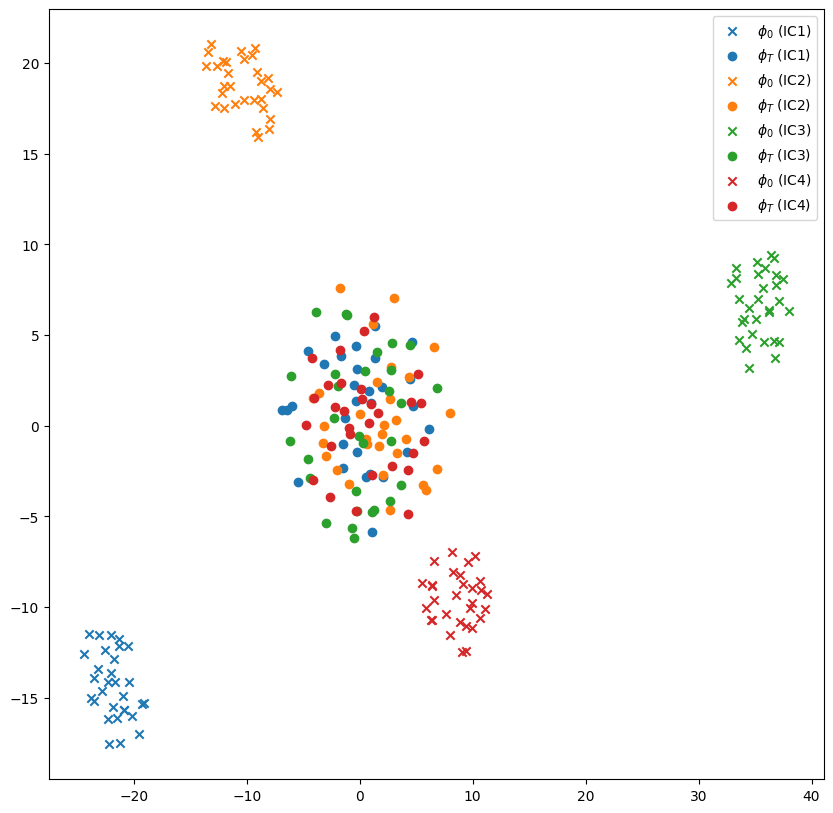

In [63]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',   # 使用颜色编码定义颜色
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
plt.figure(figsize=(10, 10))
plt.scatter(x_reduced[0:30, 0], x_reduced[0:30, 1], c=colors[0], marker='x', label=r'$\phi_0$ (IC1)')
plt.scatter(x_reduced_rand[0:30, 0], x_reduced_rand[0:30, 1], c=colors[0], label=r'$\phi_T$ (IC1)')
plt.scatter(x_reduced[30:60, 0], x_reduced[30:60, 1], c=colors[1], marker='x', label=r'$\phi_0$ (IC2)')
plt.scatter(x_reduced_rand[30:60, 0], x_reduced_rand[30:60, 1], c=colors[1], label=r'$\phi_T$ (IC2)')
plt.scatter(x_reduced[60:90, 0], x_reduced[60:90, 1], c=colors[2], marker='x', label=r'$\phi_0$ (IC3)')
plt.scatter(x_reduced_rand[60:90, 0], x_reduced_rand[60:90, 1], c=colors[2], label=r'$\phi_T$ (IC3)')
plt.scatter(x_reduced[90:120, 0], x_reduced[90:120, 1], c=colors[3], marker='x', label=r'$\phi_0$ (IC4)')
plt.scatter(x_reduced_rand[90:120, 0], x_reduced_rand[90:120, 1], c=colors[3], label= r'$\phi_T$ (IC4)')
plt.legend()
plt.savefig('../assets/burgers/tsne.png', dpi=300, bbox_inches='tight')

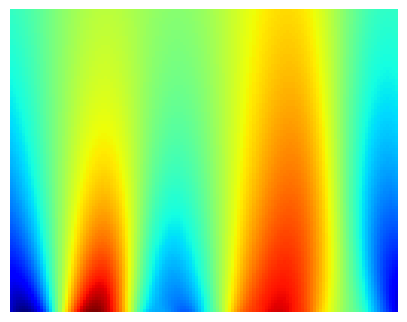

In [76]:
plt.figure(figsize=(5, 5))
plt.imshow(x4.squeeze(), cmap='jet', origin='lower')
plt.axis('off')
plt.savefig('../assets/burgers/tsne_sol4.png', dpi=300, bbox_inches='tight')

In [77]:
x_pred02ec_repeat1_mean = torch.mean(x_pred02ec_repeat1, dim=0).squeeze()
x_pred02ec_repeat1_std = torch.std(x_pred02ec_repeat1, dim=0).squeeze()
x_pred02ec_repeat2_mean = torch.mean(x_pred02ec_repeat2, dim=0).squeeze()
x_pred02ec_repeat2_std = torch.std(x_pred02ec_repeat2, dim=0).squeeze()
x_pred02ec_repeat3_mean = torch.mean(x_pred02ec_repeat3, dim=0).squeeze()
x_pred02ec_repeat3_std = torch.std(x_pred02ec_repeat3, dim=0).squeeze()
x_pred02ec_repeat4_mean = torch.mean(x_pred02ec_repeat4, dim=0).squeeze()
x_pred02ec_repeat4_std = torch.std(x_pred02ec_repeat4, dim=0).squeeze()

In [78]:
x1 = x1.squeeze()
x2 = x2.squeeze()
x3 = x3.squeeze()
x4 = x4.squeeze()

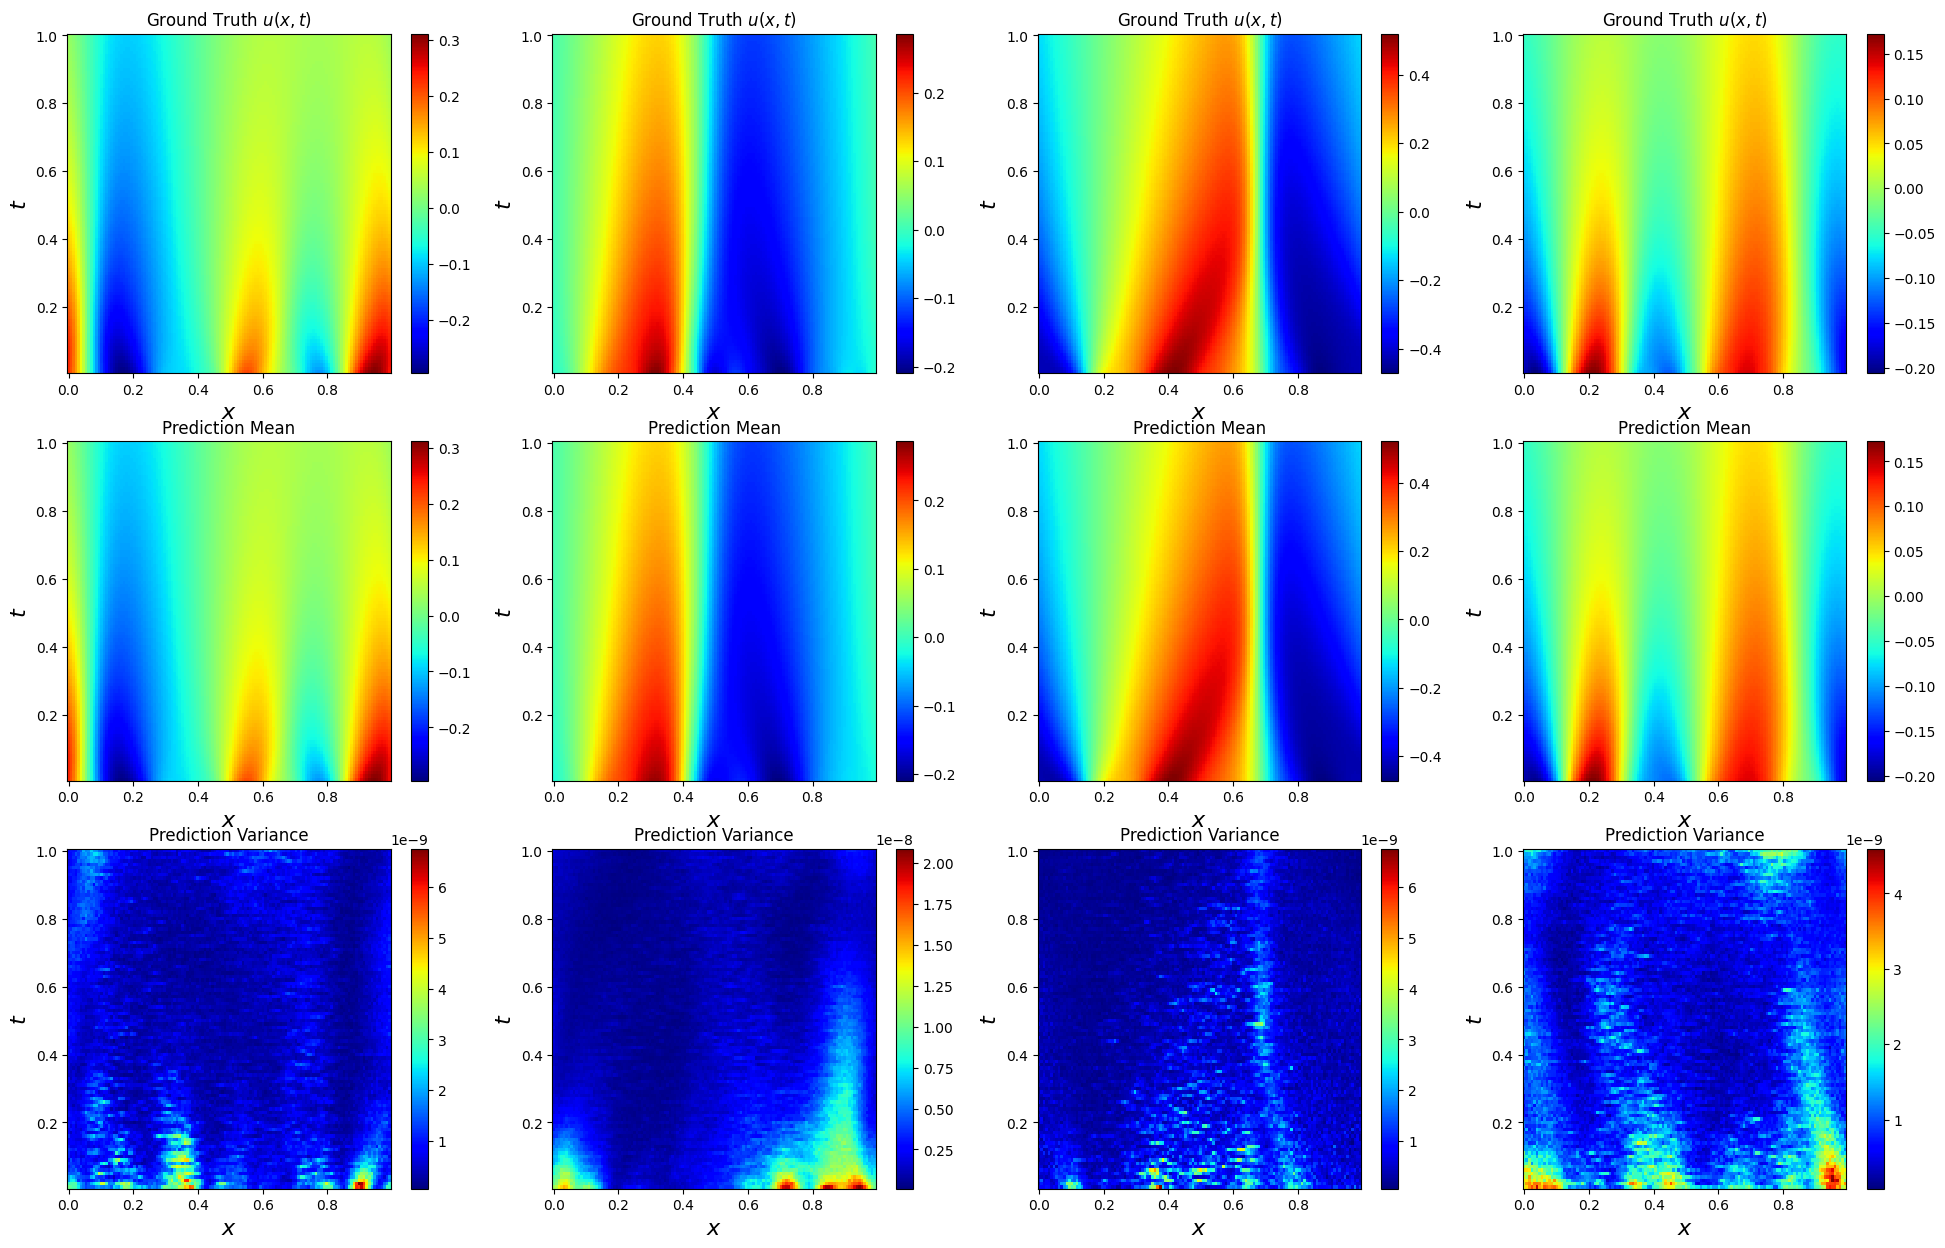

In [81]:
fig, ax = plt.subplots(3, 4, figsize=(24, 15))
norm1 = matplotlib.colors.Normalize(vmin=x1.min(), vmax=x1.max())
im1 = ax[0, 0].pcolormesh(X, T, x1.T, cmap='jet', norm=norm1)
ax[0, 0].set_xlabel('$x$', fontsize=16)
ax[0, 0].set_ylabel('$t$', fontsize=16)
ax[0, 0].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im1, ax=ax[0, 0])

im2 = ax[1, 0].pcolormesh(X, T, x_pred02ec_repeat1_mean.T, cmap='jet', norm=norm1)
ax[1, 0].set_xlabel('$x$', fontsize=16)
ax[1, 0].set_ylabel('$t$', fontsize=16)
ax[1, 0].set_title('Prediction Mean')
fig.colorbar(im2, ax=ax[1, 0])

im3 = ax[2, 0].pcolormesh(X, T, (x_pred02ec_repeat1_std**2).T, cmap='jet')
ax[2, 0].set_xlabel('$x$', fontsize=16)
ax[2, 0].set_ylabel('$t$', fontsize=16)
ax[2, 0].set_title('Prediction Variance')
fig.colorbar(im3, ax=ax[2, 0])

norm2 = matplotlib.colors.Normalize(vmin=x2.min(), vmax=x2.max())
im4 = ax[0, 1].pcolormesh(X, T, x2.T, cmap='jet', norm=norm2)
ax[0, 1].set_xlabel('$x$', fontsize=16)
ax[0, 1].set_ylabel('$t$', fontsize=16)
ax[0, 1].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im4, ax=ax[0, 1])

im5 = ax[1, 1].pcolormesh(X, T, x_pred02ec_repeat2_mean.T, cmap='jet', norm=norm2)
ax[1, 1].set_xlabel('$x$', fontsize=16)
ax[1, 1].set_ylabel('$t$', fontsize=16)
ax[1, 1].set_title('Prediction Mean')
fig.colorbar(im5, ax=ax[1, 1])

im6 = ax[2, 1].pcolormesh(X, T, (x_pred02ec_repeat2_std**2).T, cmap='jet')
ax[2, 1].set_xlabel('$x$', fontsize=16)
ax[2, 1].set_ylabel('$t$', fontsize=16)
ax[2, 1].set_title('Prediction Variance')
fig.colorbar(im6, ax=ax[2, 1])

norm3 = matplotlib.colors.Normalize(vmin=x3.min(), vmax=x3.max())
im7 = ax[0, 2].pcolormesh(X, T, x3.T, cmap='jet', norm=norm3)
ax[0, 2].set_xlabel('$x$', fontsize=16)
ax[0, 2].set_ylabel('$t$', fontsize=16)
ax[0, 2].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im7, ax=ax[0, 2])

im8 = ax[1, 2].pcolormesh(X, T, x_pred02ec_repeat3_mean.T, cmap='jet', norm=norm3)
ax[1, 2].set_xlabel('$x$', fontsize=16)
ax[1, 2].set_ylabel('$t$', fontsize=16)
ax[1, 2].set_title('Prediction Mean')
fig.colorbar(im8, ax=ax[1, 2])

ax[2, 2].pcolormesh(X, T, (x_pred02ec_repeat3_std**2).T, cmap='jet')
ax[2, 2].set_xlabel('$x$', fontsize=16)
ax[2, 2].set_ylabel('$t$', fontsize=16)
ax[2, 2].set_title('Prediction Variance')
fig.colorbar(im3, ax=ax[2, 2])

norm4 = matplotlib.colors.Normalize(vmin=x4.min(), vmax=x4.max())
im9 = ax[0, 3].pcolormesh(X, T, x4.T, cmap='jet', norm=norm4)
ax[0, 3].set_xlabel('$x$', fontsize=16)
ax[0, 3].set_ylabel('$t$', fontsize=16)
ax[0, 3].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im9, ax=ax[0, 3])

im10 = ax[1, 3].pcolormesh(X, T, x_pred02ec_repeat4_mean.T, cmap='jet', norm=norm4)
ax[1, 3].set_xlabel('$x$', fontsize=16)
ax[1, 3].set_ylabel('$t$', fontsize=16)
ax[1, 3].set_title('Prediction Mean')
fig.colorbar(im10, ax=ax[1, 3])

im11 = ax[2, 3].pcolormesh(X, T, (x_pred02ec_repeat4_std**2).T, cmap='jet')
ax[2, 3].set_xlabel('$x$', fontsize=16)
ax[2, 3].set_ylabel('$t$', fontsize=16)
ax[2, 3].set_title('Prediction Variance')
fig.colorbar(im11, ax=ax[2, 3])

In [82]:
fig.savefig('../assets/burgers/uncertainty.png', bbox_inches='tight', dpi=300)

### Different Parameters Settings Comparsion

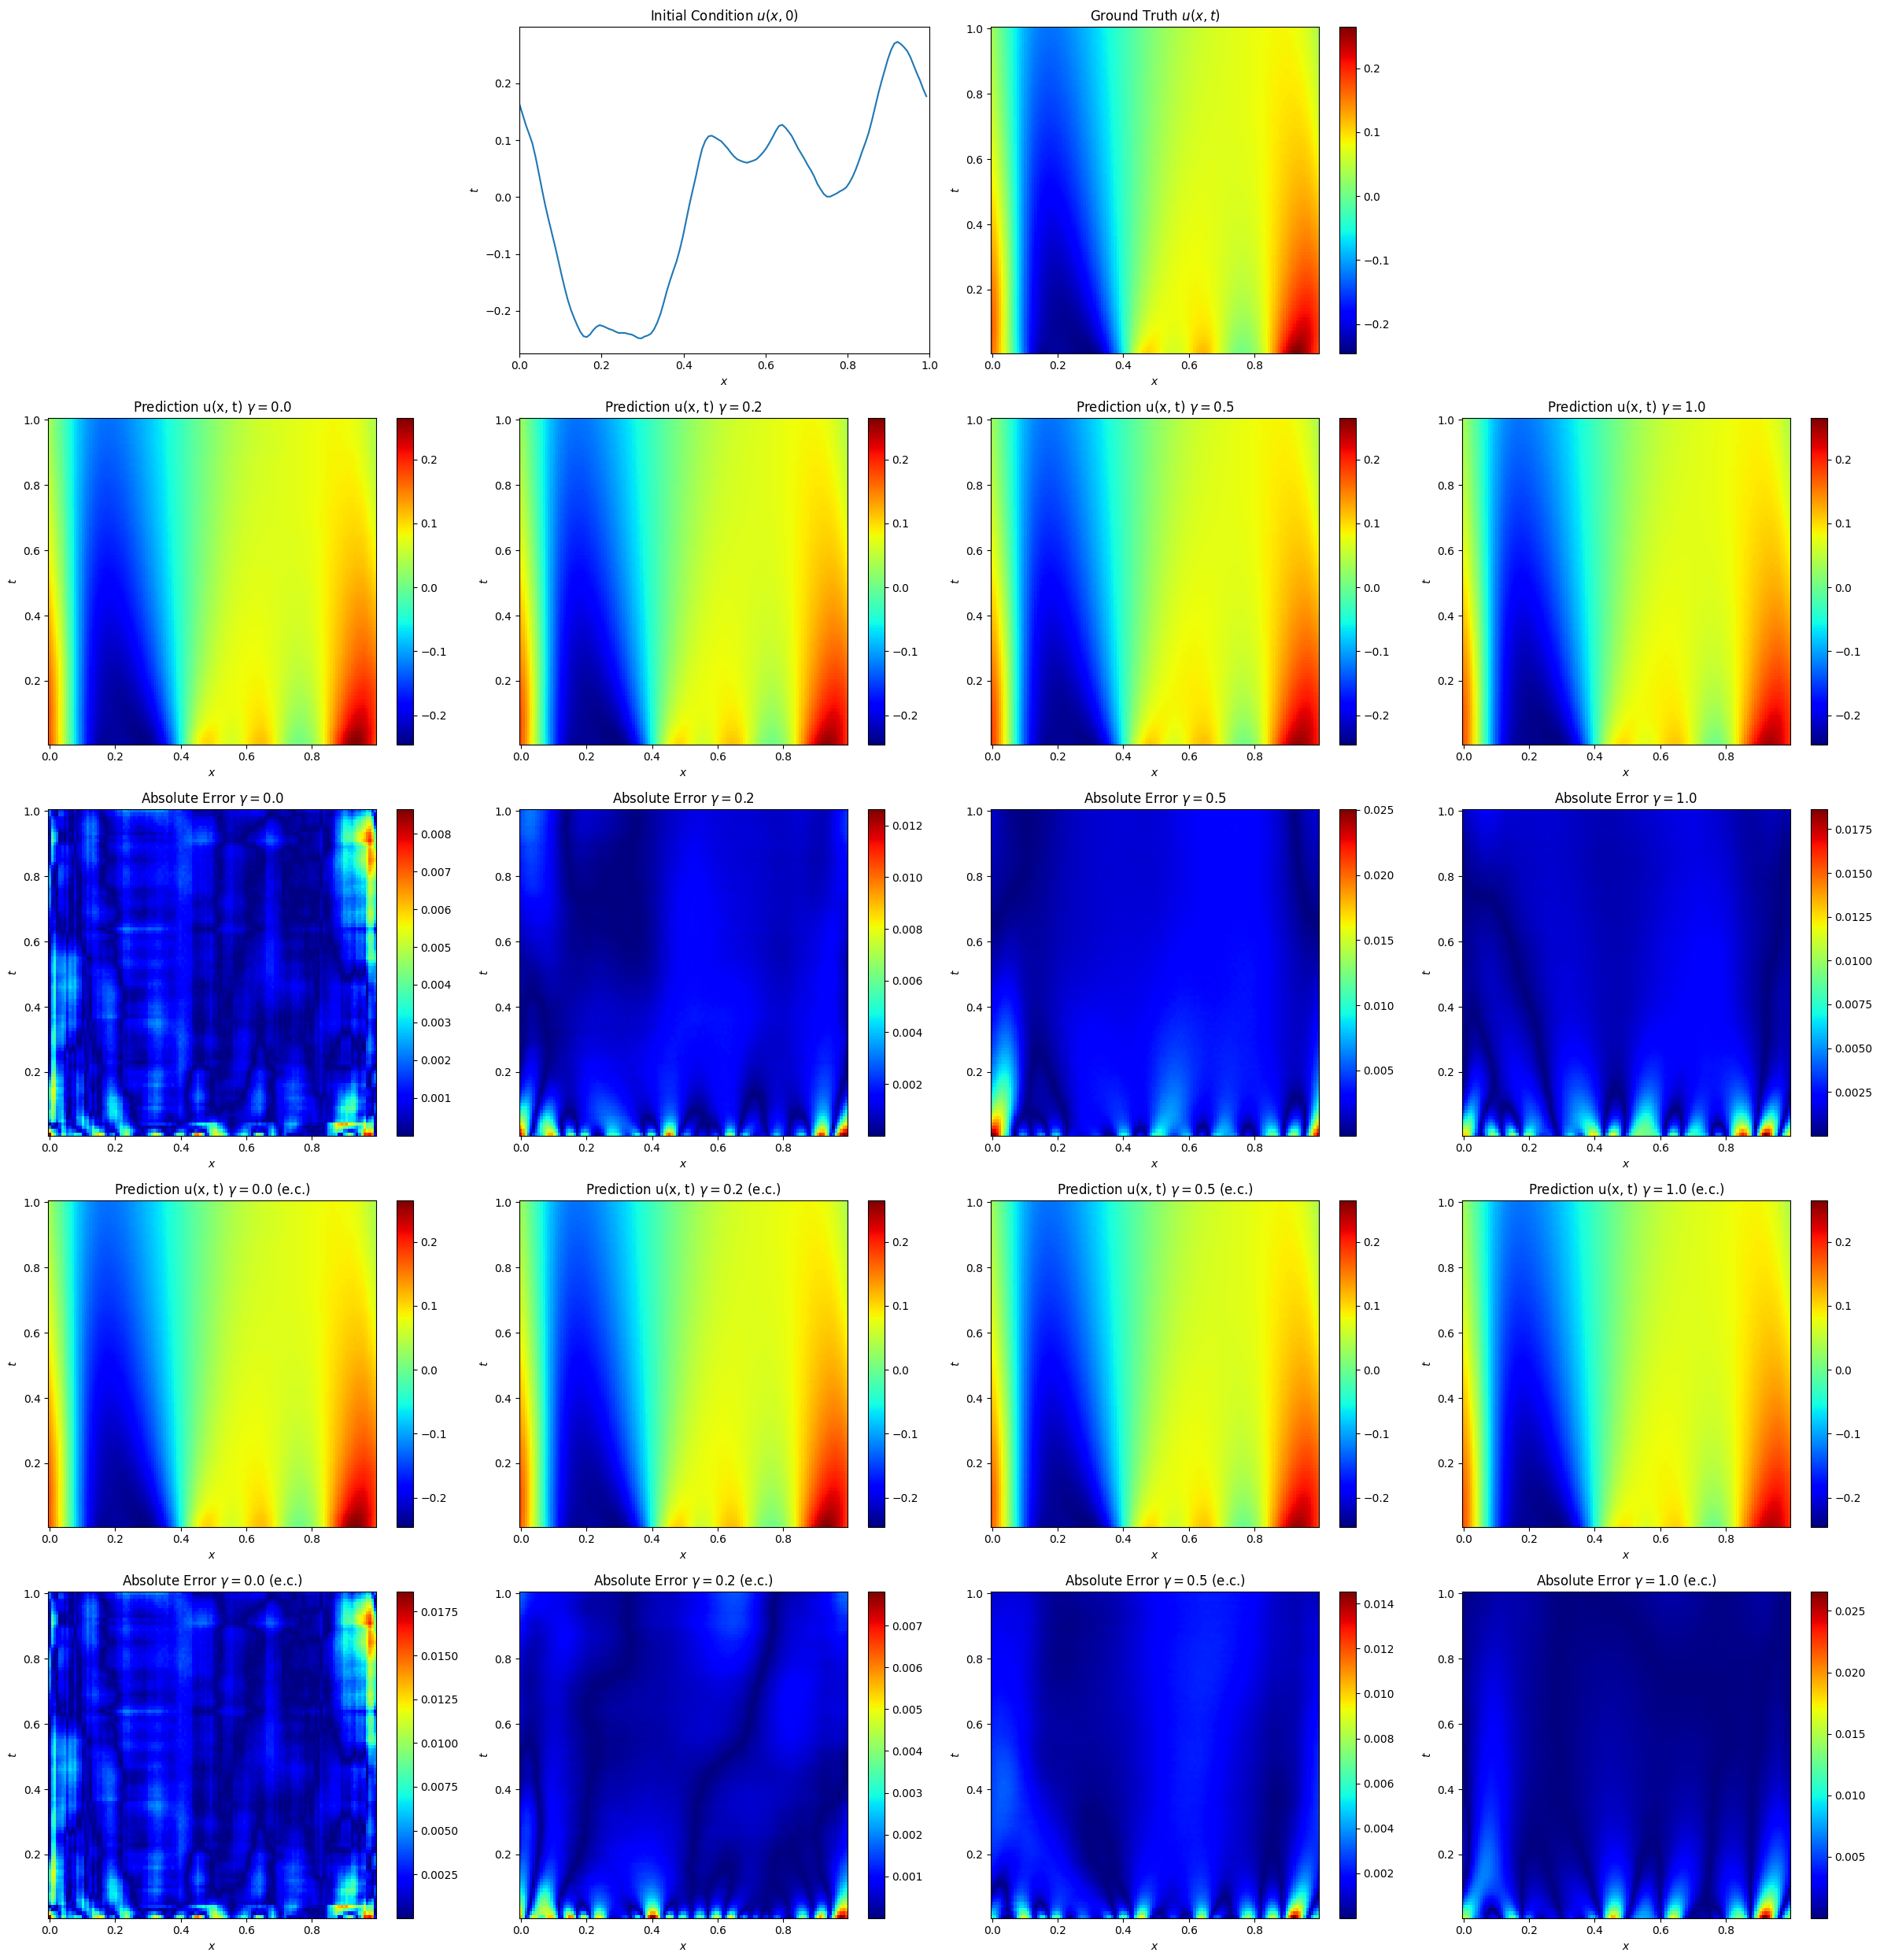

In [14]:
norm1 = matplotlib.colors.Normalize(vmin=x.min(), vmax=x.max())
norm2 = matplotlib.colors.Normalize(vmin=0, vmax=torch.abs(x).max())
fig, ax = plt.subplots(5, 4, figsize=(24, 25))
ax[0, 0].set_axis_off()
ax[0, 3].set_axis_off()

im1 = ax[0, 1].plot(x_range, y.squeeze())
ax[0, 1].set_xlabel('$x$')
ax[0, 1].set_ylabel('$t$')
ax[0, 1].set_title('Initial Condition $u(x, 0)$')
ax[0, 1].set_xlim([0, 1])
plt.tight_layout()

im2 = ax[0, 2].pcolormesh(X, T, x.T, cmap='jet', norm=norm1)
ax[0, 2].set_xlabel('$x$')
ax[0, 2].set_ylabel('$t$')
ax[0, 2].set_title('Ground Truth $u(x, t)$')
fig.colorbar(im2, ax=ax[0, 2])
plt.tight_layout()

im3 = ax[1, 0].pcolormesh(X, T, x_pred00.T, cmap='jet', norm=norm1)
ax[1, 0].set_xlabel('$x$')
ax[1, 0].set_ylabel('$t$')
ax[1, 0].set_title(r'Prediction u(x, t) $\gamma=0.0$')
fig.colorbar(im3, ax=ax[1, 0])
plt.tight_layout()

im4 = ax[1, 1].pcolormesh(X, T, x_pred02.T, cmap='jet', norm=norm1)
ax[1, 1].set_xlabel('$x$')
ax[1, 1].set_ylabel('$t$')
ax[1, 1].set_title(r'Prediction u(x, t) $\gamma=0.2$')
fig.colorbar(im4, ax=ax[1, 1])
plt.tight_layout()

im5 = ax[1, 2].pcolormesh(X, T, x_pred05.T, cmap='jet', norm=norm1)
ax[1, 2].set_xlabel('$x$')
ax[1, 2].set_ylabel('$t$')
ax[1, 2].set_title(r'Prediction u(x, t) $\gamma=0.5$')
fig.colorbar(im5, ax=ax[1, 2])
plt.tight_layout()

im6 = ax[1, 3].pcolormesh(X, T, x_pred10.T, cmap='jet', norm=norm1)
ax[1, 3].set_xlabel('$x$')
ax[1, 3].set_ylabel('$t$')
ax[1, 3].set_title(r'Prediction u(x, t) $\gamma=1.0$')
fig.colorbar(im6, ax=ax[1, 3])
plt.tight_layout()

im7 = ax[2, 0].pcolormesh(X, T, torch.abs(x_pred00-x).T, cmap='jet')
ax[2, 0].set_xlabel('$x$')
ax[2, 0].set_ylabel('$t$')
ax[2, 0].set_title(r'Absolute Error $\gamma=0.0$')
fig.colorbar(im7, ax=ax[2, 0])
plt.tight_layout()

im8 = ax[2, 1].pcolormesh(X, T, torch.abs(x_pred02-x).T, cmap='jet')
ax[2, 1].set_xlabel('$x$')
ax[2, 1].set_ylabel('$t$')
ax[2, 1].set_title(r'Absolute Error $\gamma=0.2$')
fig.colorbar(im8, ax=ax[2, 1])
plt.tight_layout()

im9 = ax[2, 2].pcolormesh(X, T, torch.abs(x_pred05-x).T, cmap='jet')
ax[2, 2].set_xlabel('$x$')
ax[2, 2].set_ylabel('$t$')
ax[2, 2].set_title(r'Absolute Error $\gamma=0.5$')
fig.colorbar(im9, ax=ax[2, 2])
plt.tight_layout()

im10 = ax[2, 3].pcolormesh(X, T, torch.abs(x_pred10-x).T, cmap='jet')
ax[2, 3].set_xlabel('$x$')
ax[2, 3].set_ylabel('$t$')
ax[2, 3].set_title(r'Absolute Error $\gamma=1.0$')
fig.colorbar(im10, ax=ax[2, 3])
plt.tight_layout()

im11 = ax[3, 0].pcolormesh(X, T, x_pred00.T, cmap='jet', norm=norm1)
ax[3, 0].set_xlabel('$x$')
ax[3, 0].set_ylabel('$t$')
ax[3, 0].set_title(r'Prediction u(x, t) $\gamma=0.0$ (e.c.)')
fig.colorbar(im11, ax=ax[3, 0])
plt.tight_layout()

im12 = ax[3, 1].pcolormesh(X, T, x_pred02ec.T, cmap='jet', norm=norm1)
ax[3, 1].set_xlabel('$x$')
ax[3, 1].set_ylabel('$t$')
ax[3, 1].set_title(r'Prediction u(x, t) $\gamma=0.2$ (e.c.)')
fig.colorbar(im12, ax=ax[3, 1])
plt.tight_layout()

im13 = ax[3, 2].pcolormesh(X, T, x_pred05ec.T, cmap='jet', norm=norm1)
ax[3, 2].set_xlabel('$x$')
ax[3, 2].set_ylabel('$t$')
ax[3, 2].set_title(r'Prediction u(x, t) $\gamma=0.5$ (e.c.)')
fig.colorbar(im13, ax=ax[3, 2])
plt.tight_layout()

im14 = ax[3, 3].pcolormesh(X, T, x_pred10ec.T, cmap='jet', norm=norm1)
ax[3, 3].set_xlabel('$x$')
ax[3, 3].set_ylabel('$t$')
ax[3, 3].set_title(r'Prediction u(x, t) $\gamma=1.0$ (e.c.)')
fig.colorbar(im14, ax=ax[3, 3])
plt.tight_layout()

im15 = ax[4, 0].pcolormesh(X, T, torch.abs(x_pred00-x).T, cmap='jet')
ax[4, 0].set_xlabel('$x$')
ax[4, 0].set_ylabel('$t$')
ax[4, 0].set_title(r'Absolute Error $\gamma=0.0$ (e.c.)')
fig.colorbar(im10, ax=ax[4, 0])
plt.tight_layout()

im16 = ax[4, 1].pcolormesh(X, T, torch.abs(x_pred02ec-x).T, cmap='jet')
ax[4, 1].set_xlabel('$x$')
ax[4, 1].set_ylabel('$t$')
ax[4, 1].set_title(r'Absolute Error $\gamma=0.2$ (e.c.)')
fig.colorbar(im16, ax=ax[4, 1])
plt.tight_layout()

im17 = ax[4, 2].pcolormesh(X, T, torch.abs(x_pred05ec-x).T, cmap='jet')
ax[4, 2].set_xlabel('$x$')
ax[4, 2].set_ylabel('$t$')
ax[4, 2].set_title(r'Absolute Error $\gamma=0.5$ (e.c.)')
fig.colorbar(im17, ax=ax[4, 2])
plt.tight_layout()

im18 = ax[4, 3].pcolormesh(X, T, torch.abs(x_pred10ec-x).T, cmap='jet')
ax[4, 3].set_xlabel('$x$')
ax[4, 3].set_ylabel('$t$')
ax[4, 3].set_title(r'Absolute Error $\gamma=1.0$ (e.c.)')
fig.colorbar(im18, ax=ax[4, 3])
plt.tight_layout()

In [15]:
fig.savefig('../assets/burgers/parameters_comparsion.png', bbox_inches='tight', dpi=300)

In [47]:
def cal_nRMSE(x, x_pred):
    norm1 = torch.linalg.norm(x-x_pred, dim=(-1, -2)).squeeze()
    norm2 = torch.linalg.norm(x, dim=(-1, -2)).squeeze()
    mean = torch.sqrt(norm1**2 / norm2**2).mean(dim=0)
    std = torch.sqrt(norm1**2 / norm2**2).std(dim=0)
    return {'mean': mean, 'std': std}

In [48]:
nRMSE00 = cal_nRMSE(x, x_pred00)
nRMSE02 = cal_nRMSE(x, x_pred02)
nRMSE05 = cal_nRMSE(x, x_pred05)
nRMSE10 = cal_nRMSE(x, x_pred10)
nRMSE02ec = cal_nRMSE(x, x_pred02ec)
nRMSE05ec = cal_nRMSE(x, x_pred05ec)
nRMSE10ec = cal_nRMSE(x, x_pred10ec)

In [50]:
print(f"nRMSE for 0.0 physics loss: {nRMSE00['mean']:.4f} ± {nRMSE00['std']:.4f}")
print(f"nRMSE for 0.2 physics loss: {nRMSE02['mean']:.4f} ± {nRMSE02['std']:.4f}")
print(f"nRMSE for 0.5 physics loss: {nRMSE05['mean']:.4f} ± {nRMSE05['std']:.4f}")
print(f"nRMSE for 1.0 physics loss: {nRMSE10['mean']:.4f} ± {nRMSE10['std']:.4f}")
print(f"nRMSE for 0.2 physics loss (e.c.): {nRMSE02ec['mean']:.4f} ± {nRMSE02ec['std']:.4f}")
print(f"nRMSE for 0.5 physics loss (e.c.): {nRMSE05ec['mean']:.4f} ± {nRMSE05ec['std']:.4f}")
print(f"nRMSE for 1.0 physics loss (e.c.): {nRMSE10ec['mean']:.4f} ± {nRMSE10ec['std']:.4f}")

nRMSE for 0.0 physics loss: 0.0150 ± 0.0155
nRMSE for 0.2 physics loss: 0.0307 ± 0.0493
nRMSE for 0.5 physics loss: 0.0312 ± 0.0386
nRMSE for 1.0 physics loss: 0.0379 ± 0.0463
nRMSE for 0.2 physics loss (e.c.): 0.0139 ± 0.0129
nRMSE for 0.5 physics loss (e.c.): 0.0275 ± 0.0319
nRMSE for 1.0 physics loss (e.c.): 0.0304 ± 0.0323


In [51]:
def cal_bRMSE(x, x_pred):
    x_boundary = x.clone()
    x_boundary[..., :, 1:-1] = 0
    x_pred_boundary = x_pred.clone()
    x_pred_boundary[..., :, 1:-1] = 0
    norm1 = torch.linalg.norm(x_boundary-x_pred_boundary, dim=(-1, -2)).squeeze()
    norm2 = torch.linalg.norm(x_boundary, dim=(-1, -2)).squeeze()
    mean = torch.sqrt(norm1**2 / norm2**2).mean(dim=0)
    std = torch.sqrt(norm1**2 / norm2**2).std(dim=0)
    return {'mean': mean, 'std': std}

In [52]:
bRMSE00 = cal_bRMSE(x, x_pred00)
bRMSE02 = cal_bRMSE(x, x_pred02)
bRMSE05 = cal_bRMSE(x, x_pred05)
bRMSE10 = cal_bRMSE(x, x_pred10)
bRMSE02ec = cal_bRMSE(x, x_pred02ec)
bRMSE05ec = cal_bRMSE(x, x_pred05ec)
bRMSE10ec = cal_bRMSE(x, x_pred10ec)

In [53]:
print(f"bRMSE for 0.0 physics loss: {bRMSE00['mean']:.4f} ± {bRMSE00['std']:.4f}")
print(f"bRMSE for 0.2 physics loss: {bRMSE02['mean']:.4f} ± {bRMSE02['std']:.4f}")
print(f"bRMSE for 0.5 physics loss: {bRMSE05['mean']:.4f} ± {bRMSE05['std']:.4f}")
print(f"bRMSE for 1.0 physics loss: {bRMSE10['mean']:.4f} ± {bRMSE10['std']:.4f}")
print(f"bRMSE for 0.2 physics loss (e.c.): {bRMSE02ec['mean']:.4f} ± {bRMSE02ec['std']:.4f}")
print(f"bRMSE for 0.5 physics loss (e.c.): {bRMSE05ec['mean']:.4f} ± {bRMSE05ec['std']:.4f}")
print(f"bRMSE for 1.0 physics loss (e.c.): {bRMSE10ec['mean']:.4f} ± {bRMSE10ec['std']:.4f}")

bRMSE for 0.0 physics loss: 0.0455 ± 0.0353
bRMSE for 0.2 physics loss: 0.0372 ± 0.0415
bRMSE for 0.5 physics loss: 0.0536 ± 0.0622
bRMSE for 1.0 physics loss: 0.0621 ± 0.0611
bRMSE for 0.2 physics loss (e.c.): 0.0259 ± 0.0223
bRMSE for 0.5 physics loss (e.c.): 0.0405 ± 0.0374
bRMSE for 1.0 physics loss (e.c.): 0.0556 ± 0.0532


In [57]:
def cal_temporal_abs_error(x, x_pred):
    norm1 = torch.linalg.norm(x-x_pred, dim=-1).squeeze()
    norm2 = torch.linalg.norm(x, dim=-1).squeeze()
    mean = torch.sqrt(norm1**2 / norm2**2).mean(dim=0)
    std = torch.sqrt(norm1**2 / norm2**2).std(dim=0)
    return {'mean': mean, 'std': std}

In [58]:
t_nRMSE00 = cal_temporal_abs_error(x, x_pred00)
t_nRMSE02 = cal_temporal_abs_error(x, x_pred02)
t_nRMSE05 = cal_temporal_abs_error(x, x_pred05)
t_nRMSE10 = cal_temporal_abs_error(x, x_pred10)
t_nRMSE02ec = cal_temporal_abs_error(x, x_pred02ec)
t_nRMSE05ec = cal_temporal_abs_error(x, x_pred05ec)
t_nRMSE10ec = cal_temporal_abs_error(x, x_pred10ec)

(0.0, 1.0)

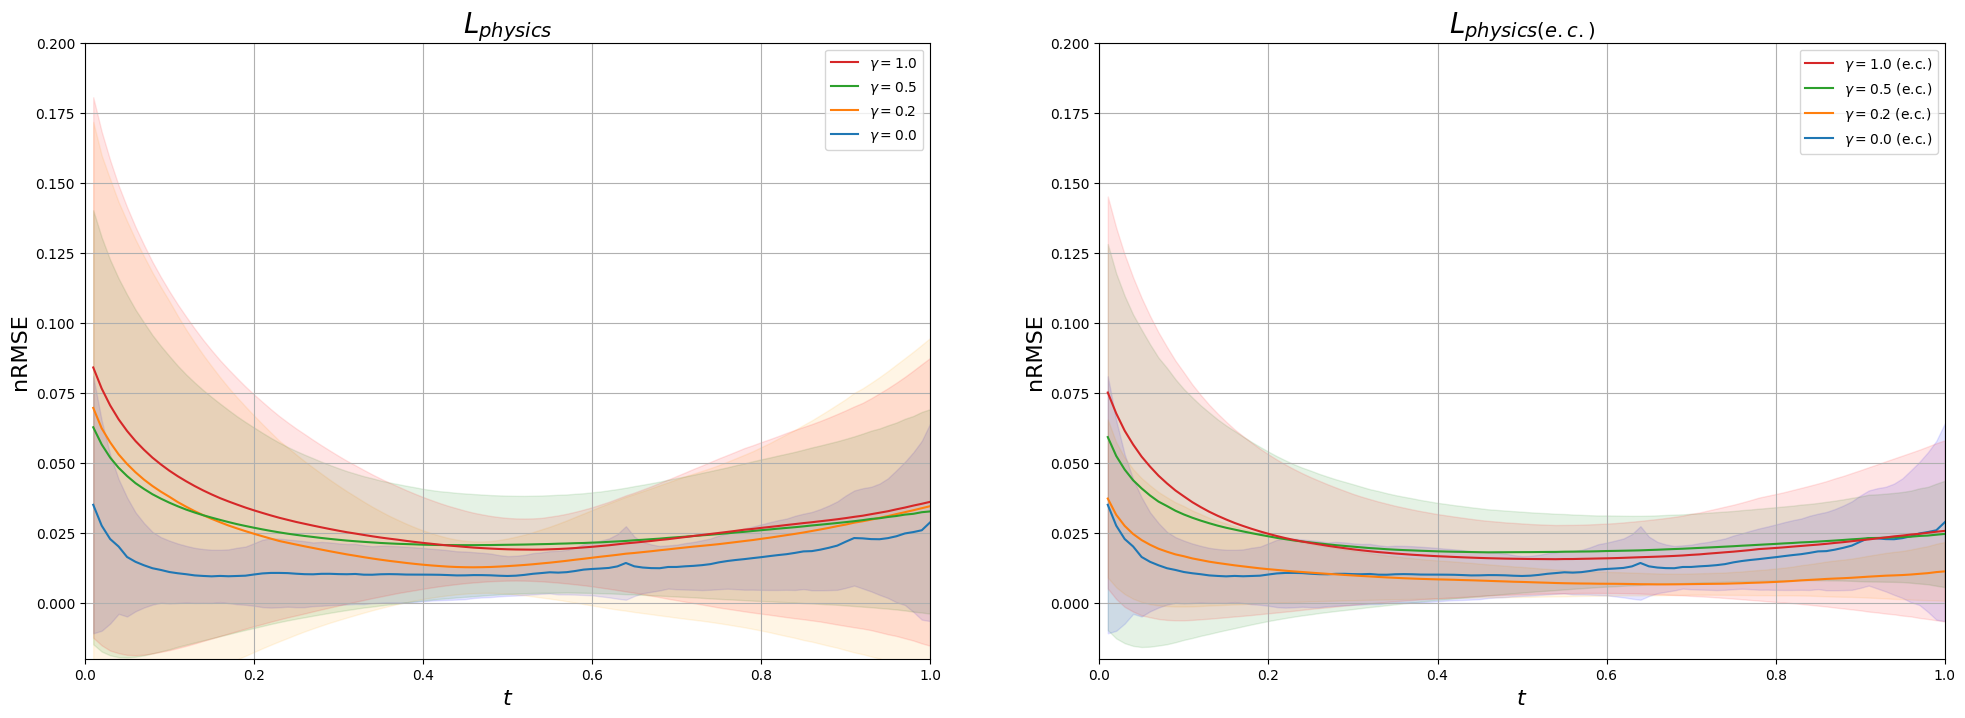

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8))
ax[0].plot(t_range, t_nRMSE00['mean'], label=r'$\gamma=0.0$')
ax[0].fill_between(t_range, t_nRMSE00['mean']-t_nRMSE00['std'], t_nRMSE00['mean']+t_nRMSE00['std'], color='blue', alpha=0.1)
ax[0].plot(t_range, t_nRMSE02['mean'], label=r'$\gamma=0.2$')
ax[0].fill_between(t_range, t_nRMSE02['mean']-t_nRMSE02['std'], t_nRMSE02['mean']+t_nRMSE02['std'], color='orange', alpha=0.1)
ax[0].plot(t_range, t_nRMSE05['mean'], label=r'$\gamma=0.5$')
ax[0].fill_between(t_range, t_nRMSE05['mean']-t_nRMSE05['std'], t_nRMSE05['mean']+t_nRMSE05['std'], color='green', alpha=0.1)
ax[0].plot(t_range, t_nRMSE10['mean'], label=r'$\gamma=1.0$')
ax[0].fill_between(t_range, t_nRMSE10['mean']-t_nRMSE10['std'], t_nRMSE10['mean']+t_nRMSE10['std'], color='red', alpha=0.1)
ax[0].set_xlabel('$t$', fontsize=16)
ax[0].set_ylabel('nRMSE', fontsize=16)
# add legend in ax[0]
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], loc='upper right')
ax[0].grid()
ax[0].set_ylim([-0.02, 0.2])
ax[0].set_xlim([0, 1])
ax[0].set_title(r'$L_{physics}$', fontsize=20)
# set log scale to y axis

ax[1].plot(t_range, t_nRMSE00['mean'], label=r'$\gamma=0.0$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE00['mean']-t_nRMSE00['std'], t_nRMSE00['mean']+t_nRMSE00['std'], color='blue', alpha=0.1)
ax[1].plot(t_range, t_nRMSE02ec['mean'], label=r'$\gamma=0.2$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE02ec['mean']-t_nRMSE02ec['std'], t_nRMSE02ec['mean']+t_nRMSE02ec['std'], color='orange', alpha=0.1)
ax[1].plot(t_range, t_nRMSE05ec['mean'], label=r'$\gamma=0.5$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE05ec['mean']-t_nRMSE05ec['std'], t_nRMSE05ec['mean']+t_nRMSE05ec['std'], color='green', alpha=0.1)
ax[1].plot(t_range, t_nRMSE10ec['mean'], label=r'$\gamma=1.0$ (e.c.)')
ax[1].fill_between(t_range, t_nRMSE10ec['mean']-t_nRMSE10ec['std'], t_nRMSE10ec['mean']+t_nRMSE10ec['std'], color='red', alpha=0.1)
ax[1].set_xlabel('$t$', fontsize=16)
ax[1].set_ylabel('nRMSE', fontsize=16)
ax[1].set_title(r'$L_{physics(e.c.)}$', fontsize=20)
handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend(handles[::-1], labels[::-1], loc='upper right')
ax[1].grid()
ax[1].set_ylim([-0.02, 0.2])
ax[1].set_xlim([0, 1])

In [61]:
fig.savefig('../assets/burgers/temporal_nRMSE.png', bbox_inches='tight', dpi=300)

### Physics Loss

In [62]:
from physics_loss import Burgers_loss

In [63]:
def cal_statistic_burgers_loss(u):
    u_list = torch.split(u, 1, dim=0)
    losses = [Burgers_loss(u) for u in u_list]
    losses = torch.stack(losses)
    return {'mean': torch.mean(losses), 'std': torch.std(losses)}

In [65]:
x_phy = cal_statistic_burgers_loss(x)
x_pred00_phy = cal_statistic_burgers_loss(x_pred00)
x_pred02_phy = cal_statistic_burgers_loss(x_pred02)
x_pred05_phy = cal_statistic_burgers_loss(x_pred05)
x_pred10_phy = cal_statistic_burgers_loss(x_pred10)
x_pred02ec_phy = cal_statistic_burgers_loss(x_pred02ec)
x_pred05ec_phy = cal_statistic_burgers_loss(x_pred05ec)
x_pred10ec_phy = cal_statistic_burgers_loss(x_pred10ec)

In [68]:
print(f"Physics loss reference: {x_phy['mean']:.4e} ± {x_phy['std']:.4e}")
print(f"Physics loss for 0.0 physics loss: {x_pred00_phy['mean']:.4e} ± {x_pred00_phy['std']:.4e}")
print(f"Physics loss for 0.2 physics loss: {x_pred02_phy['mean']:.4e} ± {x_pred02_phy['std']:.4e}")
print(f"Physics loss for 0.5 physics loss: {x_pred05_phy['mean']:.4e} ± {x_pred05_phy['std']:.4e}")
print(f"Physics loss for 1.0 physics loss: {x_pred10_phy['mean']:.4e} ± {x_pred10_phy['std']:.4e}")
print(f"Physics loss for 0.2 physics loss (e.c.): {x_pred02ec_phy['mean']:.4e} ± {x_pred02ec_phy['std']:.4e}")
print(f"Physics loss for 0.5 physics loss (e.c.): {x_pred05ec_phy['mean']:.4e} ± {x_pred05ec_phy['std']:.4e}")
print(f"Physics loss for 1.0 physics loss (e.c.): {x_pred10ec_phy['mean']:.4e} ± {x_pred10ec_phy['std']:.4e}")

Physics loss reference: 4.2951e-06 ± 3.9544e-06
Physics loss for 0.0 physics loss: 6.6961e-02 ± 3.5465e-02
Physics loss for 0.2 physics loss: 2.6689e-04 ± 1.3702e-04
Physics loss for 0.5 physics loss: 6.3837e-04 ± 7.9969e-05
Physics loss for 1.0 physics loss: 2.6738e-04 ± 1.4121e-04
Physics loss for 0.2 physics loss (e.c.): 9.1936e-05 ± 3.9741e-05
Physics loss for 0.5 physics loss (e.c.): 1.6430e-04 ± 5.2850e-05
Physics loss for 1.0 physics loss (e.c.): 1.7412e-04 ± 6.0612e-05
